______________________________________
# <center>**Trabajo Practico Nº1 para la Materia *Organización de Datos***</center>

*Integrantes*: 
- 103963	Carolina Di Matteo	cdimatteo@fi.uba.ar
- 101231	Pablo Salvador Dimartino	pdimartino@fi.uba.ar
- 100113	Juan Sebastian Burgos	jsburgos@fi.uba.ar
- 104415	Valentina Laura Correa	vcorrea@fi.uba.ar

*Grupo*: 14

*Repositorio*: [github](https://github.com/valencorrea/7506R-2C2022-GRUPO14)

*Curso*: Rodriguez

*Cuatrimestre*: 2c2022
______________________________________



**Set Up**

In [1]:
pip install 'dtreeviz'

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: "'dtreeviz'"


In [2]:
#Importación de librerías
import dtreeviz.trees as dtreeviz

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

import pandas as pd

import seaborn as sns

import scipy as sc

import sklearn as sk
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, KFold, RandomizedSearchCV, train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, confusion_matrix, precision_recall_curve, roc_curve, recall_score, accuracy_score, f1_score

#Configuración de Warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

#Ejecución con Drive
#from google.colab import drive
#drive.mount('/content/drive')
#properati=pd.read_csv('/content/drive/MyDrive/📔 Organización de Datos (75.06)/TPS/TP1/properati_argentina_2021.csv')
properati=pd.read_csv('properati_argentina_2021.csv')

#  **1. Análisis Exploratorio y Preprocesamiento de Datos**

## **1a. Exploración Inicial**


A continuación se realizará un análisis general de cada una de las variables presentes en el dataframe.

In [3]:
df = properati.copy()
df.dtypes

id                           object
start_date                   object
end_date                     object
created_on                   object
latitud                     float64
longitud                    float64
place_l2                     object
place_l3                     object
place_l4                     object
place_l5                     object
place_l6                    float64
operation                    object
property_type                object
property_rooms              float64
property_bedrooms           float64
property_surface_total      float64
property_surface_covered    float64
property_price              float64
property_currency            object
property_title               object
dtype: object

Actualmente los únicos dos tipos de datos que tenemos son Float64 y Object.

Viendo las primeras entradas, podemos observar que el tipo Object oculta fechas que se adecuan mejor al tipo de datos DateTime.

In [4]:
df.head()

id  start_date    end_date  created_on    latitud  \
0  XZq2dFGxBiboHY3Bo/tqlw==  2021-09-09  2022-01-27  2021-09-09 -38.957632   
1  8afoK+yMH/rnnlYiktwgNA==  2021-09-09  2021-10-23  2021-09-09 -34.888878   
2  iVaG5rBB47dd1Ya4BMXREA==  2021-09-09  2022-03-09  2021-09-09 -32.488717   
3  QE1QVMWKAHWkd0qT0FtPWA==  2021-09-09  2022-01-27  2021-09-09 -34.900165   
4  tJ5lSk7IysG/71OGhacNZA==  2021-09-09  2022-01-27  2021-09-09 -38.954528   

    longitud    place_l2 place_l3 place_l4 place_l5  place_l6 operation  \
0 -68.105443     Neuquén      NaN      NaN      NaN       NaN     Venta   
1 -56.092368  Montevideo      NaN      NaN      NaN       NaN     Venta   
2 -58.257499  Entre Ríos      NaN      NaN      NaN       NaN     Venta   
3 -54.808453   Maldonado      NaN      NaN      NaN       NaN     Venta   
4 -68.041862     Neuquén      NaN      NaN      NaN       NaN     Venta   

  property_type  property_rooms  property_bedrooms  property_surface_total  \
0          Casa             6.0                NaN                     NaN   
1          Casa             4.0                3.0                   193.0   
2          Casa             NaN                NaN                   110.0   
3          Casa             NaN                3.0                     NaN   
4            PH             3.0                2.0                     NaN   

   property_surface_covered  property_price property_currency  \
0                     206.0             NaN               NaN   
1                     193.0        390000.0               USD   
2                      45.0         47000.0               USD   
3                     180.0        400000.0               USD   
4                      98.0        102000.0               USD   

       property_title  
0      Casa - Capital  
1       Casa - Malvín  
2      Casa - Uruguay  
3    Casa - El Chorro  
4  PH - Villa Farrell

### Preparación de los datasets

---

Aplicamos los filtros necesarios que figuran en los requerimientos, y cambiamos el dtype de las fechas a DateTime. 

Por otro lado, determinamos tanto el modelo a entrenar como el que usaremos para realizar las predicciones.

In [5]:
df = df.loc[df['property_type'].isin(["Casa", "PH", "Departamento"])].loc[df['place_l2'].isin(["Capital Federal"])].loc[df['operation'].isin(["Venta"])].loc[df['property_currency'].isin(["USD"])]
df['start_date']= pd.to_datetime(df['start_date'])
df['created_on']= pd.to_datetime(df['created_on'])
df.replace(to_replace="9999-12-31", value="", inplace=True)
df['end_date']= pd.to_datetime(df['end_date'])
df.drop("operation", inplace=True, axis=1)
df.drop("property_currency", inplace=True, axis=1)
df.drop("property_title", inplace=True, axis=1)
train = df.sample(frac=0.8, random_state=200)
test = df.drop(train.index)
df.columns.tolist()

['id',
 'start_date',
 'end_date',
 'created_on',
 'latitud',
 'longitud',
 'place_l2',
 'place_l3',
 'place_l4',
 'place_l5',
 'place_l6',
 'property_type',
 'property_rooms',
 'property_bedrooms',
 'property_surface_total',
 'property_surface_covered',
 'property_price']

### Descripción de Campos

---

`id`: Identificador del aviso

`start_date`: Fecha de alta del aviso

`end_date`: Fecha de baja del aviso

`created_on`: Fecha de alta de la primera versión del aviso

`latitud`: Ubicación geográfica

`longitud`: Ubicación geográfica

`place_l2`: Nivel administrativo 2, usualmente provincia

`place_l3`: Nivel administrativo 3, usualmente ciudad

`place_l4`: Nivel administrativo 4, usualmente barrio

`place_l5`: Nivel administrativo 5

`place_l6`: Nivel administrativo 6

`operation`: Tipo de operación (venta, alquiler)

`property_type`: Tipo de propiedad (casa, departamento, ph)

`property_rooms`: Cantidad de ambientes

`property_bedrooms`: Cantidad de dormitorios

`property_surface_total`: Superficie total en metros cuadrados

`property_surface_covered`: Superficie cubierta en metros cuadrados

`property_price`: Precio publicado en el anuncio

`property_currency`: Moneda del precio publicado

`property_title`: Título del anuncio

### Variables Cuantitativas: Medidas de Resumen

---

Calculamos, para la totalidad de las variables que nos brinda el dataset:
- media
- mediana
- q1
- q3 
- moda

In [6]:
df.describe().loc[['mean', '25%', '75%', 'std']].append(df.median().rename("median"))

latitud   longitud  place_l5  place_l6  property_rooms  \
mean   -34.591481 -58.449795       NaN       NaN        2.822799   
25%    -34.615975 -58.466522       NaN       NaN        2.000000   
75%    -34.577413 -58.408862       NaN       NaN        4.000000   
std      0.181719   0.292630       NaN       NaN        1.426148   
median -34.595790 -58.439000       NaN       NaN        3.000000   

        property_bedrooms  property_surface_total  property_surface_covered  \
mean             2.014629              109.092970                 87.931932   
25%              1.000000               45.000000                 40.000000   
75%              3.000000              105.000000                 88.000000   
std              1.129767              980.401976                990.927129   
median           2.000000               65.000000                 58.000000   

        property_price  
mean     226238.207185  
25%       95000.000000  
75%      237000.000000  
std      318603.483648  
median   143900.000000

### Variables Cualitativas: Cantidades y Frecuencias

---

Realizamos, para las variables `place_l3`, `place_l4` y `property_type` un cálculo de los diferentes valores así también como sus respectivas frecuencias.

In [7]:
print(f"place_l3 tiene {df.nunique()['place_l3']} valores diferentes")

place_l3 tiene 57 valores diferentes


<AxesSubplot: >

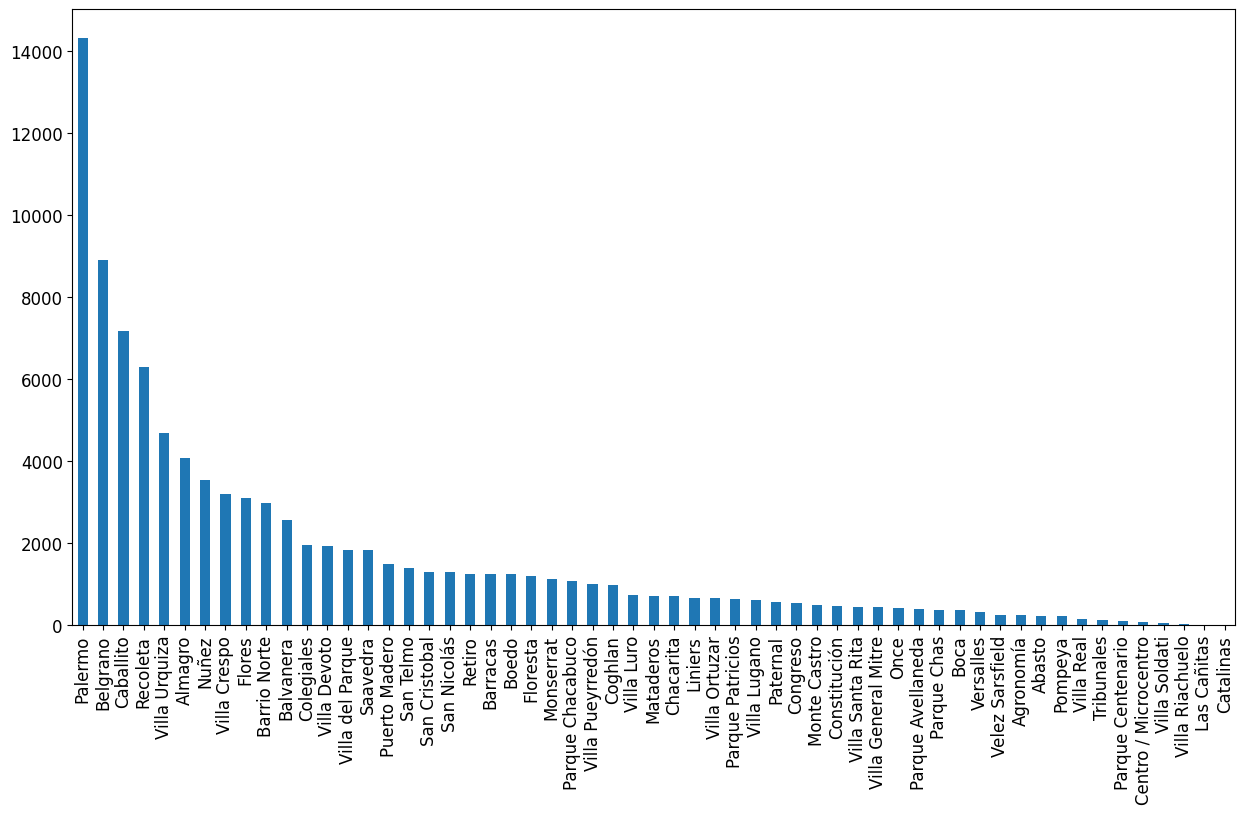

In [8]:
fig, ax = plt.subplots()
df['place_l3'].value_counts().plot(ax=ax, kind='bar', figsize=(15,8), fontsize=12)

In [9]:
print(f"place_l4 tiene {df.nunique()['place_l4']} valores diferentes")

place_l4 tiene 4 valores diferentes


<AxesSubplot: >

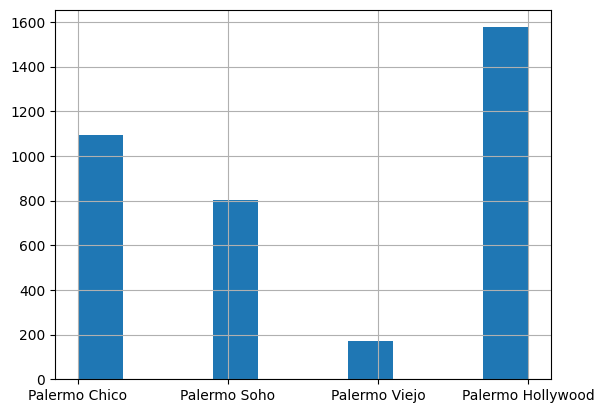

In [10]:
df['place_l4'].hist()

<AxesSubplot: >

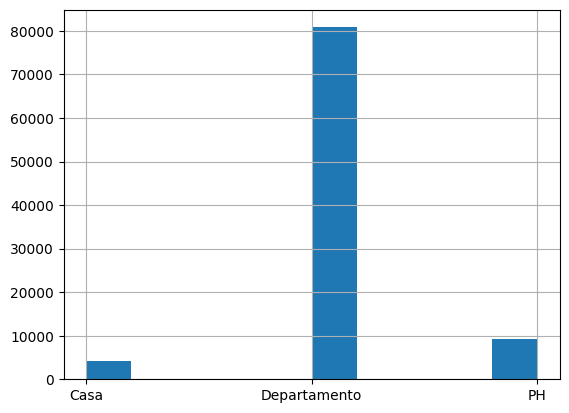

In [11]:
df['property_type'].hist()

In [12]:
print(f"property_type tiene {df.nunique()['property_type']} valores diferentes")

property_type tiene 3 valores diferentes


### Determinación de Variables Irrelevantes

---

Finalmente, podremos decir que dejamos fuera de este análisis particular a las a las siguientes variables que detallamos a continuación:

- `operation`: Sólo hay un tipo de operación según lo solicitado en la consigna y es "Venta", con lo cual la consideramos irrelevante en el análisis.
- `property_currency`: Sólo hay un tipo de cambio según lo solicitado en la consigna y es "USD", con lo cual la consideramos irrelevante en el análisis.
- `place_l5`: De analizar previamente el dataset con el cual estamos trabajando, detectamos que la columna en cuestión se encuentra vacía, con lo cual la consideramos irrelevante en el análisis.
- `place_l6`: De analizar previamente el dataset con el cual estamos trabajando, detectamos que la columna en cuestión se encuentra vacía, con lo cual la consideramos irrelevante en el análisis.
- `property_title`: De conocer previamente la información que contiene el dataset, sabemos que la variable en cuestión almacena un único título por publicación, con lo cual la consideramos irrelevante en el análisis.

### Análisis Gráfico de las Distribuciones de las Variables

---



#### Densidad de la variable `latitud`

<AxesSubplot: xlabel='latitud', ylabel='Density'>

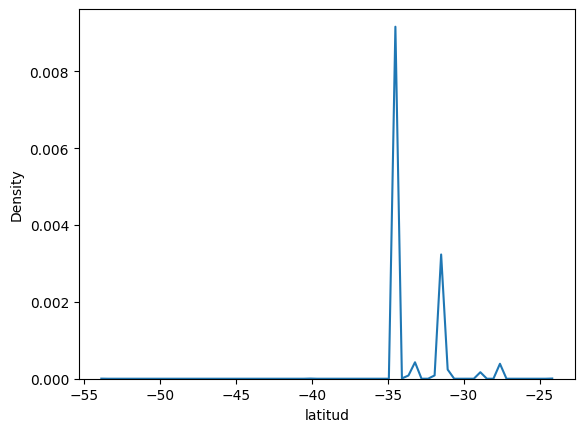

In [13]:
sns.kdeplot(data=df.latitud, gridsize=70)

#### Densidad de la variable `longitud`

<AxesSubplot: xlabel='longitud', ylabel='Density'>

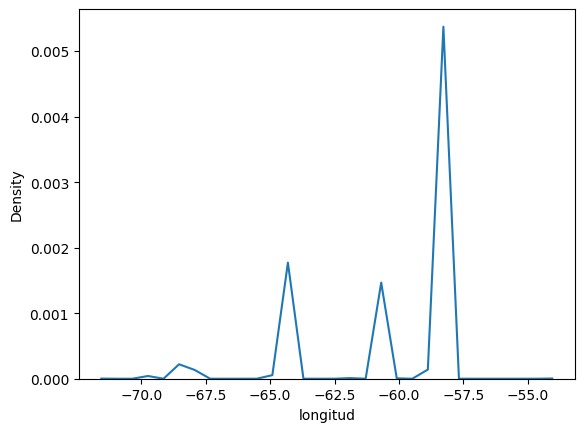

In [14]:
sns.kdeplot(data=df.longitud, gridsize=30)


#### Densidad de la variable `property_price`

<AxesSubplot: xlabel='property_price', ylabel='Density'>

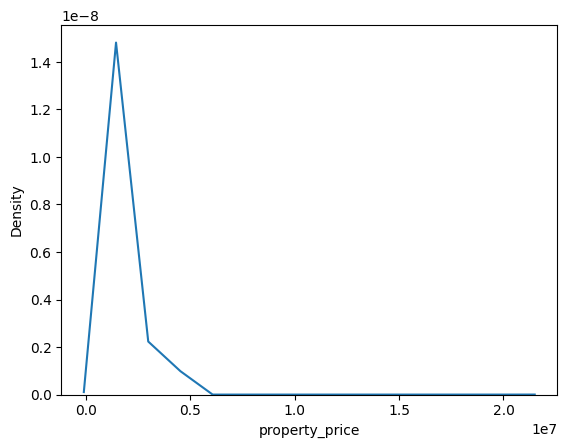

In [15]:
sns.kdeplot(data=df.property_price, gridsize=15)


#### Densidad de la variable `property_rooms`

<AxesSubplot: xlabel='property_rooms', ylabel='count'>

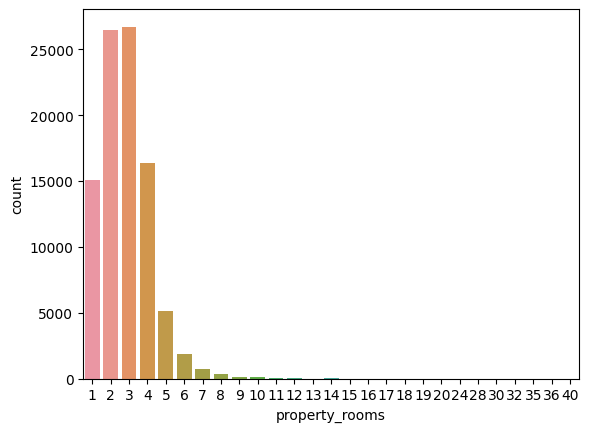

In [16]:
sns.countplot(x=df['property_rooms'].dropna().astype('int32'))

#### Densidad de la variable `property_surface_covered`

<AxesSubplot: xlabel='property_surface_covered', ylabel='Density'>

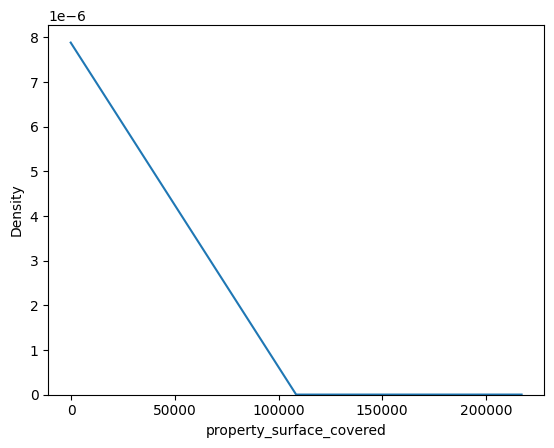

In [17]:
sns.kdeplot(data=df.property_surface_covered, gridsize=3)


### Análisis de las Correlaciones existentes entre las Variables

---

In [18]:
df.drop(["place_l5", "place_l6"], axis = 1, inplace = True)

In [19]:
columns = df.columns.tolist()
df_pariplot = df[columns].copy()
# graf_pairplot = sns.pairplot(data=df_pariplot, hue="property_type", palette=["r", "g", "b"])

## **1b. Datos Faltantes**

A continuación se realizara un análisis sobre los datos faltantes del dataframe.

Creamos una copia del dataset hasta el momento para comparar más adelante.

In [20]:
df_copy = df.copy()

### Análisis a Nivel Columna

---



Graficamos, para cada variable, el porcentaje (diferente de cero) de datos faltantes con respecto al total del dataset en escala logarítmica.

<AxesSubplot: >

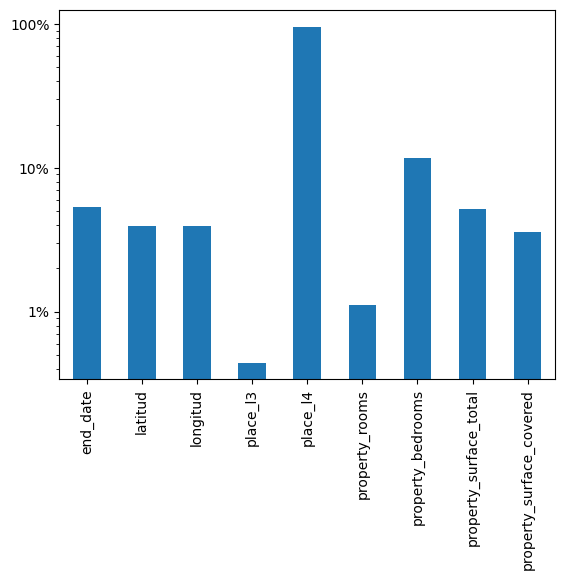

In [21]:
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.yaxis.set_major_formatter(PercentFormatter())
(df.isnull().sum() * 100 / len(df)).replace(0,np.nan).dropna(axis=0,how="all").plot(ax=ax, kind='bar')

### Análisis a Nivel Fila

---



Graficamos el porcentaje de filas con n datos faltantes con respecto al total del dataset.

<AxesSubplot: >

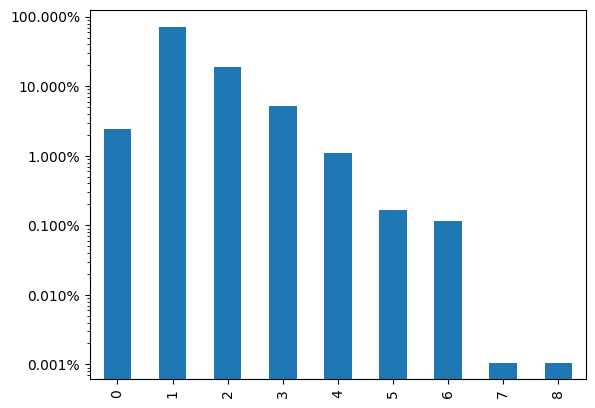

In [22]:
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.yaxis.set_major_formatter(PercentFormatter(decimals=3))
(df.isnull().sum(axis=1).value_counts().sort_index() * 100 / len(df)).plot(ax=ax, kind='bar')

### Reparación de Valores Faltantes

---



A continuación se detallan posibles estrategias para reparar los valores faltantes del dataset.

Reemplazamos las locaciones no definidas por el nivel superior

In [23]:
df.place_l3.fillna(df.place_l2, inplace=True)
df.place_l4.fillna(df.place_l3, inplace=True)

Reemplazamos la cantidad de dormitorios no definidos por la media calculada filtrando por cantidad total de habitaciones.


In [24]:
cant = df.loc[(df['property_bedrooms'].isna()) & (df['property_rooms'].notna())].property_rooms.value_counts().index.values

for i in cant:
    median = df.loc[(df['property_bedrooms'].notna()) & (df['property_rooms'] == i)].property_bedrooms.median()
    df.loc[(df['property_bedrooms'].isna()) & (df["property_rooms"] == i), "property_bedrooms"] = df.loc[(df['property_bedrooms'].isna()) & (df["property_rooms"] == i), "property_bedrooms"].fillna(median)


Luego reemplazamos la cantidad total de habitaciones no definidas por la media calculada filtrando por cantidad de dormitorios.

Esto redujo el porcentaje de valores no definidos para los dormitorios y habitaciones a menos de 1%, desde 10% y 1,5% respectivamente.

<AxesSubplot: >

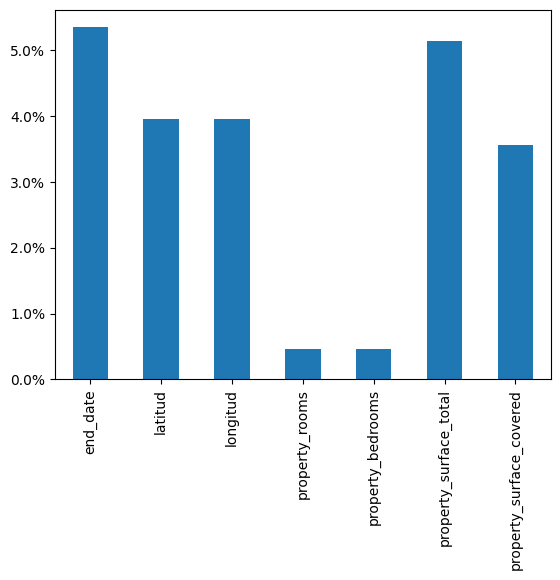

In [25]:
cant = df.loc[(df['property_rooms'].isna()) & (df['property_bedrooms'].notna())].property_bedrooms.value_counts().index.values

for i in cant:
    median = df.loc[(df['property_rooms'].notna()) & (df['property_bedrooms'] == i)].property_rooms.median()
    df.loc[(df['property_rooms'].isna()) & (df["property_bedrooms"] == i), "property_rooms"] = df.loc[(df['property_rooms'].isna()) & (df["property_bedrooms"] == i), "property_rooms"].fillna(median)
    
fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(PercentFormatter())
(df.isnull().sum() * 100 / len(df)).replace(0,np.nan).dropna(axis=0,how="all").plot(ax=ax, kind='bar')


Cuando se tiene la superficie total pero no la cubierta o viceversa, reemplazamos los valores faltantes con su contraparte

<AxesSubplot: >

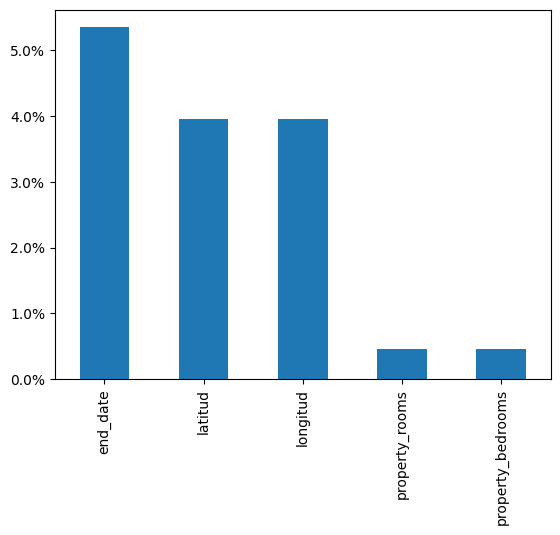

In [26]:
df.property_surface_total.fillna(df.property_surface_covered, inplace=True)
df.property_surface_covered.fillna(df.property_surface_total, inplace=True)

fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(PercentFormatter())
(df.isnull().sum() * 100 / len(df)).replace(0,np.nan).dropna(axis=0,how="all").plot(ax=ax, kind='bar')

<AxesSubplot: ylabel='Density'>

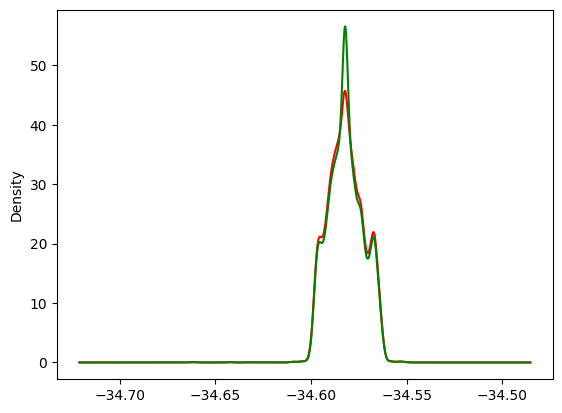

In [27]:
df.loc[df["place_l4"] == "Palermo"].latitud.plot.density(color = "red")
for barrio in df["place_l4"].unique() :
    lat_median = df.loc[(df["place_l4"] == barrio) & (df['latitud'].notna()) ].latitud.median()
    df.loc[(df["place_l4"] == barrio) & (df['latitud'].isna()), "latitud"] = df.loc[(df["place_l4"] == barrio) & (df['latitud'].isna()), "latitud"].fillna(lat_median)

df.loc[df["place_l4"] == "Palermo"].latitud.plot.density(color = "green")

<AxesSubplot: ylabel='Density'>

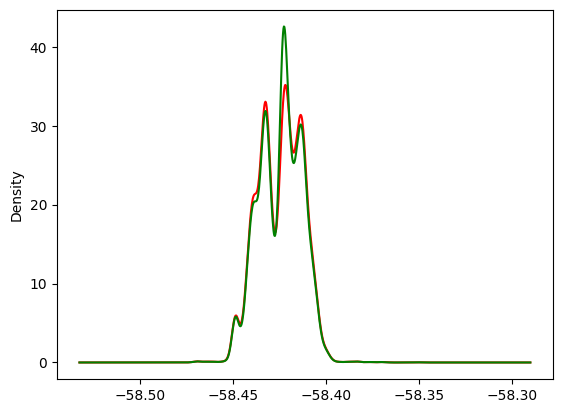

In [28]:
df.loc[df["place_l4"] == "Palermo"].longitud.plot.density(color = "red")
for barrio in df["place_l4"].unique() :
    long_median = df.loc[(df["place_l4"] == barrio) & (df['longitud'].notna())].longitud.median()
    df.loc[(df["place_l4"] == barrio) & (df['longitud'].isna()), "longitud"] = df.loc[(df["place_l4"] == barrio) & (df['longitud'].isna()), "longitud"].fillna(long_median)
    
df.loc[df["place_l4"] == "Palermo"].longitud.plot.density(color = "green")

<AxesSubplot: >

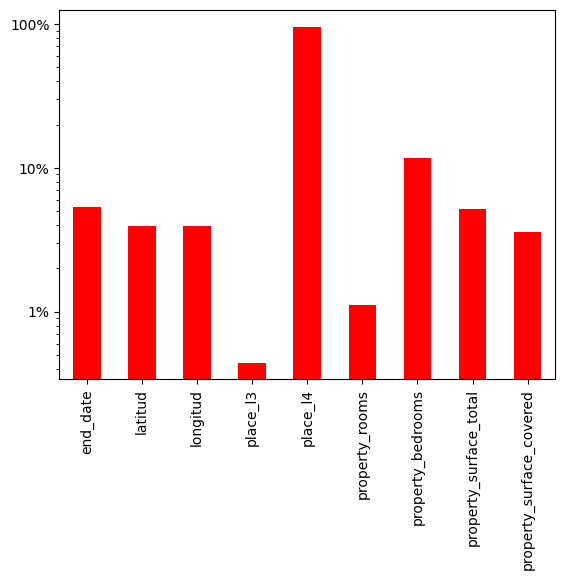

In [29]:
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.yaxis.set_major_formatter(PercentFormatter())
(df_copy.isnull().sum() * 100 / len(df_copy)).replace(0,np.nan).dropna(axis=0,how="all").plot(ax=ax, kind='bar', color="red", zorder=0)

<AxesSubplot: >

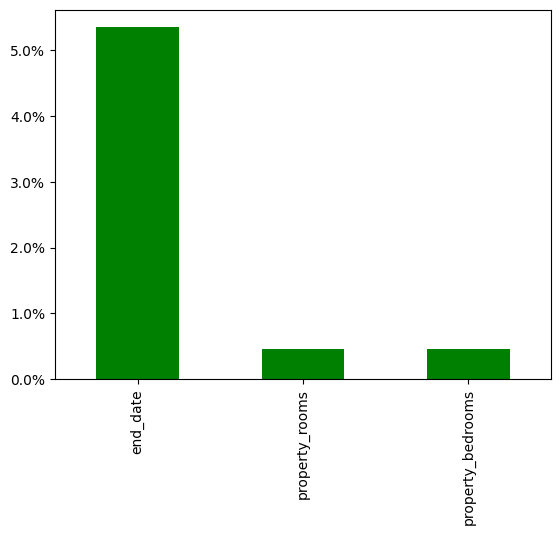

In [30]:
fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(PercentFormatter())
(df.isnull().sum() * 100 / len(df)).replace(0,np.nan).dropna(axis=0,how="all").plot(ax=ax, kind='bar', color="green", zorder=1)

## **1c. Valores atípicos**

A continuación se realizara un análisis sobre los valores atípicos presentes en el dataframe. En la totalidad del dataset logramos detectar outliers tanto univariados (presentes en una unica variable) como multivariados (se encuentran en un espacio n-dimensional).

### Outliers univariados

---

Para el análisis de outliers de tipo univariados estaremos utilizando tanto el método de Box Plot como los métodos de Z-Score y Z-Score Modificado.

Mientras que el primero nos brindará información respecto de los topes superiores e inferiores de los cuartiles Q3 y Q1 respectivamente, los gráficos de Z-Score y Z-Score modificado nos permitirán visualizar de forma eficiente cómo se distribuye la masa de observaciones respecto de la media, y -por tanto- poder determinar de forma más precisa cuáles son los valores atípicos.

Por último, podremos destacar cuáles son las características de los valores en cuestión pudiendo clasificar los mismos en: global, contextual y colectivo.

#### Property rooms

##### Box plot

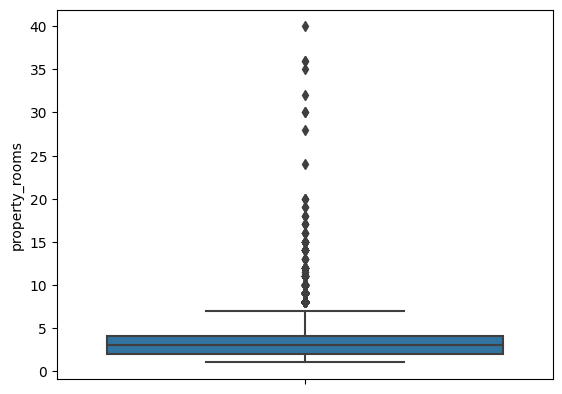

In [31]:
sns.boxplot(y=df.property_rooms)
plt.show()

In [32]:
Q1_property_rooms=df.describe().get("property_rooms").get("25%")
Q3_property_rooms=df.describe().get("property_rooms").get("75%")

print("El valor de Q1 es:", Q1_property_rooms)
print("El valor de Q3 es:", Q3_property_rooms)

IQR_property_rooms=Q3_property_rooms-Q1_property_rooms

out_inf=Q1_property_rooms-1.5*IQR_property_rooms
out_sup=Q3_property_rooms+1.5*IQR_property_rooms
print("El limite inferior del Q1 es:", out_inf)
print("El limite superior del Q3 es:", out_sup)

El valor de Q1 es: 2.0
El valor de Q3 es: 4.0
El limite inferior del Q1 es: -1.0
El limite superior del Q3 es: 7.0


##### Z-Score

In [33]:
media_rooms=np.mean(df.property_rooms)
std_rooms=np.std(df.property_rooms)
df['z_rooms']=(df.property_rooms - media_rooms)/std_rooms

Estudiamos si existen datos para el método de Z-Score utilizando la regla de oro (|Z|>3).

In [34]:
df[df['z_rooms']>3].head()

id start_date   end_date created_on    latitud  \
58    tgaK6Ibor1zLY5bvNxsXfw== 2021-09-09 2021-09-26 2021-09-09 -34.633730   
834   DW1aOtw9rrmcRJKrXV8lQQ== 2021-09-09 2022-03-09 2021-09-09 -34.586193   
1040  hg7z9YXumyiWLjMo6ed2Eg== 2021-09-09 2022-03-09 2021-09-09 -34.620750   
1108  emutcNxb0N+nIgC7KPMFow== 2021-09-09 2022-03-09 2021-09-09 -34.620750   
1349  fwH71WfOi+vE4kdGMHfWNQ== 2021-09-09 2022-03-09 2021-09-09 -34.620750   

       longitud         place_l2         place_l3         place_l4  \
58   -58.424729  Capital Federal            Boedo            Boedo   
834  -58.396815  Capital Federal         Recoleta         Recoleta   
1040 -58.502759  Capital Federal       Villa Luro       Villa Luro   
1108 -58.502759  Capital Federal     Monte Castro     Monte Castro   
1349 -58.502759  Capital Federal  Velez Sarsfield  Velez Sarsfield   

     property_type  property_rooms  property_bedrooms  property_surface_total  \
58            Casa            10.0               10.0                   394.0   
834   Departamento             9.0                4.0                   390.0   
1040          Casa             8.0                6.0                   201.0   
1108          Casa             8.0                6.0                   201.0   
1349          Casa             8.0                6.0                   201.0   

      property_surface_covered  property_price   z_rooms  
58                       244.0        500000.0  4.992871  
834                      340.0       1200000.0  4.296317  
1040                     201.0        345000.0  3.599764  
1108                     201.0        345000.0  3.599764  
1349                     201.0        345000.0  3.599764

In [35]:
df[df['z_rooms']<-3].head()

Empty DataFrame
Columns: [id, start_date, end_date, created_on, latitud, longitud, place_l2, place_l3, place_l4, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price, z_rooms]
Index: []

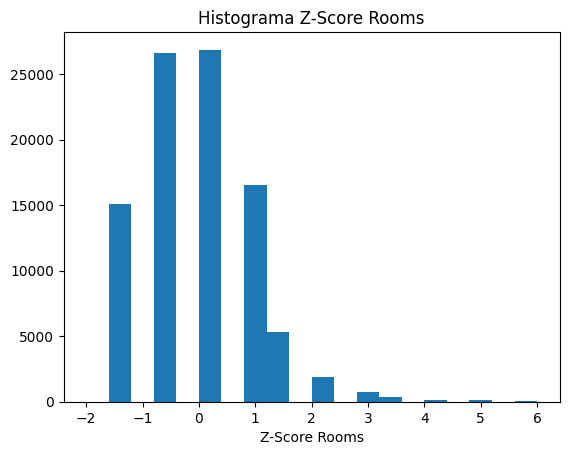

In [36]:
plt.hist(df.z_rooms, bins=20, range=(-2,6))
plt.title('Histograma Z-Score Rooms')
plt.xlabel('Z-Score Rooms')
plt.show()

##### Z-Score Modificado

In [37]:
mediana_room=np.nanmedian(df.property_rooms)

MAD=np.nanmedian(np.absolute(df.property_rooms-mediana_room))

df['zm_rooms']=(df.property_rooms - mediana_room)*0.6745/MAD

Estudiamos si existen datos para el método de Z-Score Modificado utilizando la regla de oro (|Z|>3.5).

In [38]:
df[(df['zm_rooms']>3.5)].head()

id start_date   end_date created_on    latitud  \
58    tgaK6Ibor1zLY5bvNxsXfw== 2021-09-09 2021-09-26 2021-09-09 -34.633730   
834   DW1aOtw9rrmcRJKrXV8lQQ== 2021-09-09 2022-03-09 2021-09-09 -34.586193   
1769  g1hq2MUtnOPGU2VYSr2BWw== 2021-12-17 2022-01-27 2021-12-17 -34.623581   
3071  r6wObBTHokmjYtHqvcAlyQ== 2021-02-20 2021-03-01 2021-02-20 -34.623590   
6279  Ouq4jrslx03LUpqpoVwuTg== 2021-10-29 2022-01-27 2021-10-29 -34.593211   

       longitud         place_l2       place_l3       place_l4 property_type  \
58   -58.424729  Capital Federal          Boedo          Boedo          Casa   
834  -58.396815  Capital Federal       Recoleta       Recoleta  Departamento   
1769 -58.484051  Capital Federal       Floresta       Floresta          Casa   
3071 -58.401566  Capital Federal  San Cristobal  San Cristobal            PH   
6279 -58.390512  Capital Federal       Recoleta       Recoleta  Departamento   

      property_rooms  property_bedrooms  property_surface_total  \
58              10.0               10.0                   394.0   
834              9.0                4.0                   390.0   
1769            10.0                6.0                   240.0   
3071            15.0               15.0                   355.0   
6279            10.0                5.0                   600.0   

      property_surface_covered  property_price   z_rooms  zm_rooms  
58                       244.0        500000.0  4.992871    4.7215  
834                      340.0       1200000.0  4.296317    4.0470  
1769                     240.0        320000.0  4.992871    4.7215  
3071                     215.0        220000.0  8.475638    8.0940  
6279                     600.0       2000000.0  4.992871    4.7215

In [39]:
df[(df['zm_rooms']<-3.5)].head()

Empty DataFrame
Columns: [id, start_date, end_date, created_on, latitud, longitud, place_l2, place_l3, place_l4, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price, z_rooms, zm_rooms]
Index: []

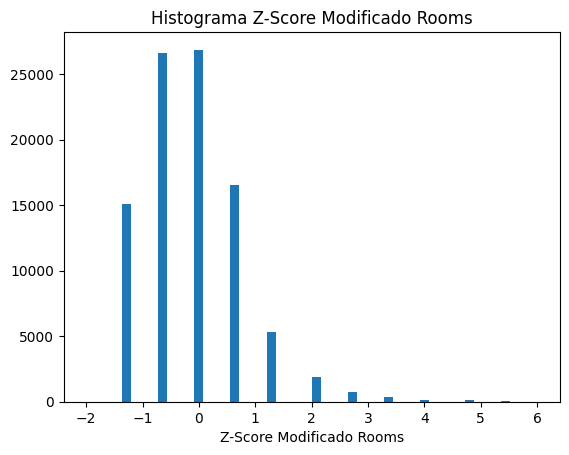

In [40]:
plt.hist(df.zm_rooms, bins=50, range=(-2,6))
plt.title('Histograma Z-Score Modificado Rooms')
plt.xlabel('Z-Score Modificado Rooms')
plt.show()

##### Características

Del análisis de los 3 gráficos previamente presentados, podemos concluir que, puesto que existe una gran masa conjunta de observaciones que superan el límite superior del tercer cuartil, podríamos decir que los outliers en cuestión son del tipo colectivo.

#### Property bedrooms

 ##### Box plot


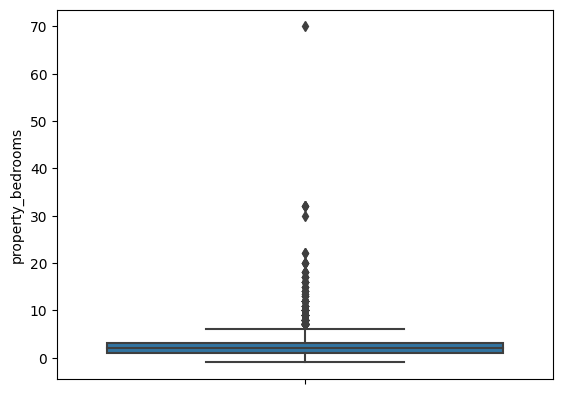

In [41]:
sns.boxplot(y=df.property_bedrooms)
plt.show()

In [42]:
Q1_property_bedrooms=df.describe().get("property_bedrooms").get("25%")
Q3_property_bedrooms=df.describe().get("property_bedrooms").get("75%")

print("El valor de Q1 es:", Q1_property_bedrooms)
print("El valor de Q3 es:", Q3_property_bedrooms)

IQR_property_bedrooms=Q3_property_bedrooms-Q1_property_bedrooms

out_inf=Q1_property_bedrooms-1.5*IQR_property_bedrooms
out_sup=Q3_property_bedrooms+1.5*IQR_property_bedrooms
print("El limite inferior del Q1 es:", out_inf)
print("El limite superior del Q3 es:", out_sup)

El valor de Q1 es: 1.0
El valor de Q3 es: 3.0
El limite inferior del Q1 es: -2.0
El limite superior del Q3 es: 6.0


##### Z-Score

In [43]:
media_bedrooms=np.mean(df.property_bedrooms)
std_bedrooms=np.std(df.property_bedrooms)
df['z_bedrooms']=(df.property_bedrooms - media_bedrooms)/std_bedrooms

Estudiamos si existen datos para el método de Z-Score utilizando la regla de oro (|Z|>3).

In [44]:
df[df['z_bedrooms']>3].head()

id start_date   end_date created_on   latitud  \
58    tgaK6Ibor1zLY5bvNxsXfw== 2021-09-09 2021-09-26 2021-09-09 -34.63373   
1040  hg7z9YXumyiWLjMo6ed2Eg== 2021-09-09 2022-03-09 2021-09-09 -34.62075   
1108  emutcNxb0N+nIgC7KPMFow== 2021-09-09 2022-03-09 2021-09-09 -34.62075   
1349  fwH71WfOi+vE4kdGMHfWNQ== 2021-09-09 2022-03-09 2021-09-09 -34.62075   
1363  rfG2Nb7079oZOP8wAKuwXA== 2021-09-09 2022-03-09 2021-09-09 -34.62075   

       longitud         place_l2          place_l3          place_l4  \
58   -58.424729  Capital Federal             Boedo             Boedo   
1040 -58.502759  Capital Federal        Villa Luro        Villa Luro   
1108 -58.502759  Capital Federal      Monte Castro      Monte Castro   
1349 -58.502759  Capital Federal   Velez Sarsfield   Velez Sarsfield   
1363 -58.502759  Capital Federal  Villa Santa Rita  Villa Santa Rita   

     property_type  property_rooms  property_bedrooms  property_surface_total  \
58            Casa            10.0               10.0                   394.0   
1040          Casa             8.0                6.0                   201.0   
1108          Casa             8.0                6.0                   201.0   
1349          Casa             8.0                6.0                   201.0   
1363          Casa             8.0                6.0                   201.0   

      property_surface_covered  property_price   z_rooms  zm_rooms  z_bedrooms  
58                       244.0        500000.0  4.992871    4.7215    7.237343  
1040                     201.0        345000.0  3.599764    3.3725    3.657724  
1108                     201.0        345000.0  3.599764    3.3725    3.657724  
1349                     201.0        345000.0  3.599764    3.3725    3.657724  
1363                     201.0        345000.0  3.599764    3.3725    3.657724

In [45]:
df[df['z_bedrooms']<-3].head()

Empty DataFrame
Columns: [id, start_date, end_date, created_on, latitud, longitud, place_l2, place_l3, place_l4, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price, z_rooms, zm_rooms, z_bedrooms]
Index: []

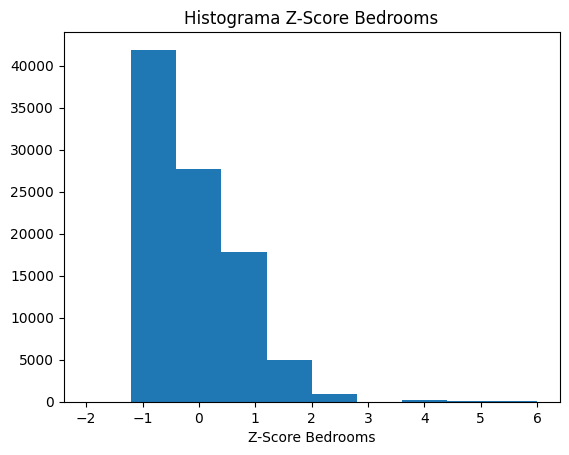

In [46]:
plt.hist(df.z_bedrooms, bins=10, range=(-2,6))
plt.title('Histograma Z-Score Bedrooms')
plt.xlabel('Z-Score Bedrooms')
plt.show()

##### Z-Score Modificado

In [47]:
mediana_bedroom=np.nanmedian(df.property_bedrooms)
MAD=np.nanmedian(np.absolute(df.property_bedrooms-mediana_bedroom))

df['zm_bedrooms']=(df.property_bedrooms - mediana_bedroom)*0.6745/MAD

Estudiamos si existen datos para el método de Z-Score Modificado utilizando la regla de oro (|Z|>3.5).

In [48]:
df[(df['zm_bedrooms']>3.5)].head()

id start_date   end_date created_on    latitud  \
58    tgaK6Ibor1zLY5bvNxsXfw== 2021-09-09 2021-09-26 2021-09-09 -34.633730   
3071  r6wObBTHokmjYtHqvcAlyQ== 2021-02-20 2021-03-01 2021-02-20 -34.623590   
6355  PZJRORTIAvMTvI3A+FLDUQ== 2021-10-29 2021-11-03 2021-10-29 -34.577180   
6920  7zvivHSapxLYLTcr6PsxAQ== 2021-02-09        NaT 2021-02-09 -34.620995   
6922  TE83wpYe7pIeb5E3T7UxuA== 2021-02-09 2021-02-10 2021-02-09 -34.623819   

       longitud         place_l2       place_l3       place_l4 property_type  \
58   -58.424729  Capital Federal          Boedo          Boedo          Casa   
3071 -58.401566  Capital Federal  San Cristobal  San Cristobal            PH   
6355 -58.451264  Capital Federal     Colegiales     Colegiales  Departamento   
6920 -58.374707  Capital Federal      San Telmo      San Telmo          Casa   
6922 -58.371153  Capital Federal      San Telmo      San Telmo          Casa   

      property_rooms  property_bedrooms  property_surface_total  \
58              10.0               10.0                   394.0   
3071            15.0               15.0                   355.0   
6355             6.0                8.0                   424.0   
6920            10.0                9.0                   511.0   
6922            11.0               10.0                   750.0   

      property_surface_covered  property_price   z_rooms  zm_rooms  \
58                       244.0        500000.0  4.992871    4.7215   
3071                     215.0        220000.0  8.475638    8.0940   
6355                     324.0        660000.0  2.206657    2.0235   
6920                     380.0        920000.0  4.992871    4.7215   
6922                     750.0       1500000.0  5.689424    5.3960   

      z_bedrooms  zm_bedrooms  
58      7.237343       5.3960  
3071   11.711866       8.7685  
6355    5.447533       4.0470  
6920    6.342438       4.7215  
6922    7.237343       5.3960

In [49]:
df[(df['zm_bedrooms']<-3.5)].head()

Empty DataFrame
Columns: [id, start_date, end_date, created_on, latitud, longitud, place_l2, place_l3, place_l4, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price, z_rooms, zm_rooms, z_bedrooms, zm_bedrooms]
Index: []

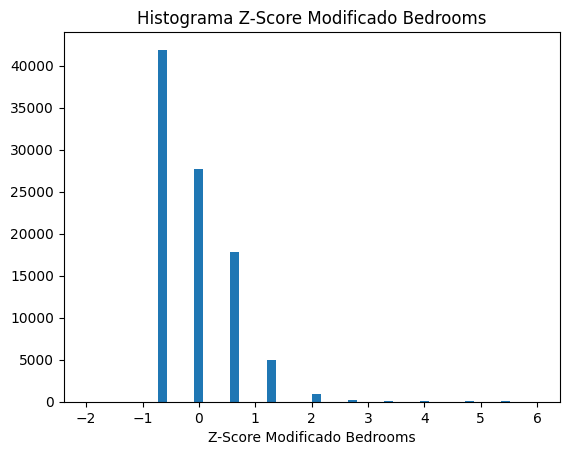

In [50]:
plt.hist(df.zm_bedrooms, bins=50, range=(-2,6))
plt.title('Histograma Z-Score Modificado Bedrooms')
plt.xlabel('Z-Score Modificado Bedrooms')
plt.show()

##### Características

Del análisis de los 3 gráficos previamente presentados, podemos concluir que, puesto que existe una gran masa conjunta de observaciones atípicas y una singular -también atípica- lejana a la masa en cuestión- podríamos decir que los outliers son del tipo colectivo (para la masa de observaciones cerca del máximo para el tercer cuartil) y global (para la singular por encima del resto de las observaciones).

#### Property price

##### Box plot

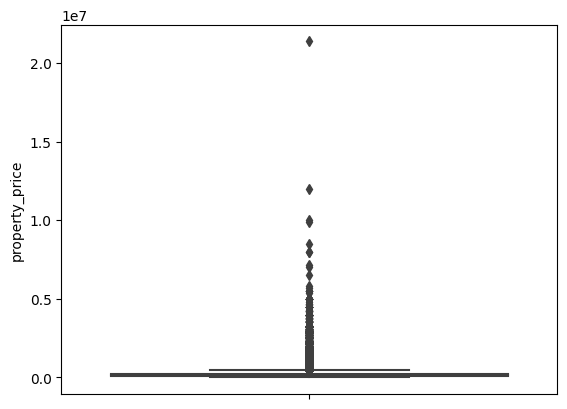

In [51]:
sns.boxplot(y=df.property_price)
plt.show()

In [52]:
Q1_property_price=df.describe().get("property_price").get("25%")
Q3_property_price=df.describe().get("property_price").get("75%")

print("El valor de Q1 es:", Q1_property_price)
print("El valor de Q3 es:", Q3_property_price)

IQR_property_price=Q3_property_price-Q1_property_price

out_inf=Q1_property_price-1.5*IQR_property_price
out_sup=Q3_property_price+1.5*IQR_property_price
print("El limite inferior del Q1 es:", out_inf)
print("El limite superior del Q3 es:", out_sup)

El valor de Q1 es: 95000.0
El valor de Q3 es: 237000.0
El limite inferior del Q1 es: -118000.0
El limite superior del Q3 es: 450000.0


##### Z-Score

In [53]:
media_price=np.mean(df.property_price)
std_price=np.std(df.property_price)
df['z_price']=(df.property_price - media_price)/std_price

Estudiamos si existen datos para el método de Z-Score utilizando la regla de oro (|Z|>3).

In [54]:
df[df['z_price']>3].head()

id start_date   end_date created_on    latitud  \
410  S8iZ1eflTJtt4bejzBVktw== 2021-09-09 2021-09-10 2021-09-09 -34.576741   
411  FblpEe26U1lQkU5vRzAtmg== 2021-09-09 2021-09-09 2021-09-09 -34.576741   
438  taPk4LSPMT26ftJm7/Bh6Q== 2021-09-09 2022-03-06 2021-09-09 -34.575053   
448  0Ui0Bm9reiNrJFdUfgXwiA== 2021-09-09 2022-01-27 2021-09-09 -34.577855   
629  1Q/fC60k0cGKYTu6hUqf1g== 2021-09-09 2021-09-11 2021-09-09 -34.566536   

      longitud         place_l2  place_l3       place_l4 property_type  \
410 -58.404830  Capital Federal   Palermo  Palermo Chico  Departamento   
411 -58.404830  Capital Federal   Palermo  Palermo Chico  Departamento   
438 -58.407958  Capital Federal   Palermo  Palermo Chico  Departamento   
448 -58.408796  Capital Federal   Palermo  Palermo Chico  Departamento   
629 -58.448246  Capital Federal  Belgrano       Belgrano  Departamento   

     property_rooms  property_bedrooms  property_surface_total  \
410             5.0                4.0                   400.0   
411             5.0                4.0                   400.0   
438             4.0                3.0                   282.0   
448             5.0                4.0                   304.0   
629             4.0                3.0                   214.0   

     property_surface_covered  property_price   z_rooms  zm_rooms  z_bedrooms  \
410                     400.0       2700000.0  1.510104    1.3490    1.867914   
411                     400.0       2700000.0  1.510104    1.3490    1.867914   
438                     256.0       2250000.0  0.813550    0.6745    0.973010   
448                     294.0       1200000.0  1.510104    1.3490    1.867914   
629                     196.0       1200000.0  0.813550    0.6745    0.973010   

     zm_bedrooms   z_price  
410       1.3490  7.764431  
411       1.3490  7.764431  
438       0.6745  6.352010  
448       1.3490  3.056360  
629       0.6745  3.056360

In [55]:
df[df['z_price']<-3].head()

Empty DataFrame
Columns: [id, start_date, end_date, created_on, latitud, longitud, place_l2, place_l3, place_l4, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price, z_rooms, zm_rooms, z_bedrooms, zm_bedrooms, z_price]
Index: []

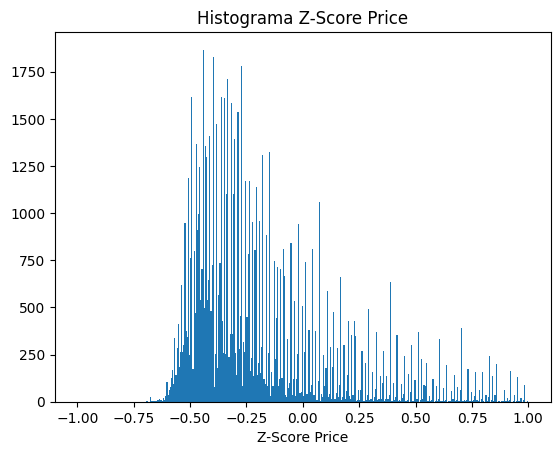

In [56]:
plt.hist(df.z_price, bins=400, range=(-1,1))
plt.title('Histograma Z-Score Price')
plt.xlabel('Z-Score Price')
plt.show()

##### Z-Score Modificado

In [57]:
mediana_price=np.nanmedian(df.property_price)
MAD=np.nanmedian(np.absolute(df.property_price-mediana_price))

df['zm_price']=(df.property_price - mediana_price)*0.6745/MAD

Estudiamos si existen datos para el método de Z-Score Modificado utilizando la regla de oro (|Z|>3.5).

In [58]:
df[(df['zm_price']>3.5)].head()

id start_date   end_date created_on    latitud  \
58   tgaK6Ibor1zLY5bvNxsXfw== 2021-09-09 2021-09-26 2021-09-09 -34.633730   
410  S8iZ1eflTJtt4bejzBVktw== 2021-09-09 2021-09-10 2021-09-09 -34.576741   
411  FblpEe26U1lQkU5vRzAtmg== 2021-09-09 2021-09-09 2021-09-09 -34.576741   
438  taPk4LSPMT26ftJm7/Bh6Q== 2021-09-09 2022-03-06 2021-09-09 -34.575053   
448  0Ui0Bm9reiNrJFdUfgXwiA== 2021-09-09 2022-01-27 2021-09-09 -34.577855   

      longitud         place_l2 place_l3       place_l4 property_type  ...  \
58  -58.424729  Capital Federal    Boedo          Boedo          Casa  ...   
410 -58.404830  Capital Federal  Palermo  Palermo Chico  Departamento  ...   
411 -58.404830  Capital Federal  Palermo  Palermo Chico  Departamento  ...   
438 -58.407958  Capital Federal  Palermo  Palermo Chico  Departamento  ...   
448 -58.408796  Capital Federal  Palermo  Palermo Chico  Departamento  ...   

     property_bedrooms  property_surface_total  property_surface_covered  \
58                10.0                   394.0                     244.0   
410                4.0                   400.0                     400.0   
411                4.0                   400.0                     400.0   
438                3.0                   282.0                     256.0   
448                4.0                   304.0                     294.0   

     property_price   z_rooms  zm_rooms  z_bedrooms  zm_bedrooms   z_price  \
58         500000.0  4.992871    4.7215    7.237343       5.3960  0.859260   
410       2700000.0  1.510104    1.3490    1.867914       1.3490  7.764431   
411       2700000.0  1.510104    1.3490    1.867914       1.3490  7.764431   
438       2250000.0  0.813550    0.6745    0.973010       0.6745  6.352010   
448       1200000.0  1.510104    1.3490    1.867914       1.3490  3.056360   

      zm_price  
58    4.141197  
410  29.725680  
411  29.725680  
438  24.492491  
448  12.281715  

[5 rows x 21 columns]

In [59]:
df[(df['zm_price']<-3.5)].head()

Empty DataFrame
Columns: [id, start_date, end_date, created_on, latitud, longitud, place_l2, place_l3, place_l4, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price, z_rooms, zm_rooms, z_bedrooms, zm_bedrooms, z_price, zm_price]
Index: []

[0 rows x 21 columns]

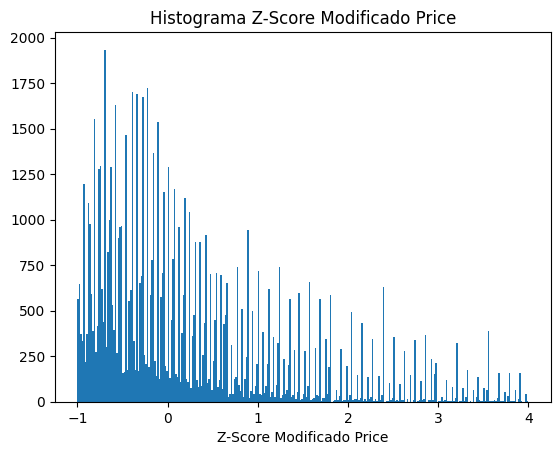

In [60]:
plt.hist(df.zm_price, bins=300, range=(-1,4))
plt.title('Histograma Z-Score Modificado Price')
plt.xlabel('Z-Score Modificado Price')
plt.show()

##### Características

Nuevamente, concluimos que al existir una gran masa conjunta de observaciones atípicas y una singular -también atípica- lejana a la masa en cuestión- podríamos decir que los outliers son del tipo colectivo (para la masa de observaciones cerca del máximo para el tercer cuartil) y global (para la observación singular por encima del resto de las observaciones).

#### Property surface covered

##### Box plot

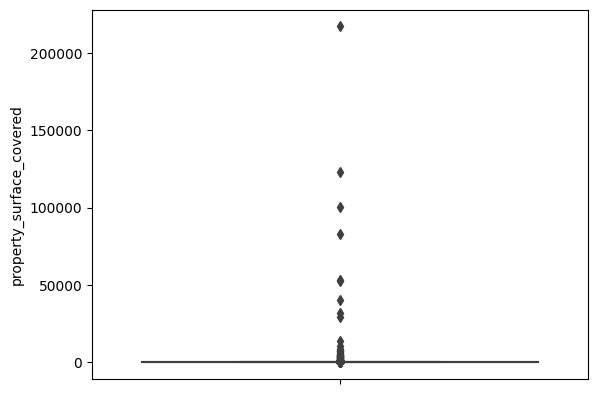

In [61]:
sns.boxplot(y=df.property_surface_covered)
plt.show()

In [62]:
Q1_property_surface_covered=df.describe().get("property_surface_covered").get("25%")
Q3_property_surface_covered=df.describe().get("property_surface_covered").get("75%")

print("El valor de Q1 es:", Q1_property_surface_covered)
print("El valor de Q3 es:", Q3_property_surface_covered)

IQR_property_surface_covered=Q3_property_surface_covered-Q1_property_surface_covered

out_inf=Q1_property_surface_covered-1.5*IQR_property_surface_covered
out_sup=Q3_property_surface_covered+1.5*IQR_property_surface_covered
print("El limite inferior del Q1 es:", out_inf)
print("El limite superior del Q3 es:", out_sup)

El valor de Q1 es: 40.0
El valor de Q3 es: 89.0
El limite inferior del Q1 es: -33.5
El limite superior del Q3 es: 162.5


##### Z-Score

In [63]:
media_surface_covered=np.mean(df.property_surface_covered)
std_surface_covered=np.std(df.property_surface_covered)
df['z_surface_covered']=(df.property_surface_covered - media_surface_covered)/std_surface_covered

Estudiamos si existen datos para el método de Z-Score utilizando la regla de oro (|Z|>3).

In [64]:
df[df['z_surface_covered']>3].head()

id start_date   end_date created_on    latitud  \
1140   ddV7Ll5c1H+Rmqqovc+uFg== 2021-09-09 2022-01-27 2021-09-09 -34.605781   
1932   eQ/SiyES/mXWsSyAzb3k3A== 2021-12-17        NaT 2021-12-17 -34.637026   
30359  rpeGyTLDvloNDFf/CSF6Aw== 2021-10-15 2022-01-27 2021-10-15 -34.620995   
72316  BPTyNzwU2D4btCduu8ls3A== 2021-05-29 2021-06-08 2021-05-29 -34.578917   
72521  csbBJk04jQXgGZLXTj5WAg== 2021-05-29 2021-06-13 2021-05-29 -34.600113   

        longitud         place_l2          place_l3          place_l4  \
1140  -58.376705  Capital Federal       San Nicolás       San Nicolás   
1932  -58.426283  Capital Federal  Parque Chacabuco  Parque Chacabuco   
30359 -58.374707  Capital Federal         San Telmo         San Telmo   
72316 -58.429373  Capital Federal           Palermo           Palermo   
72521 -58.403649  Capital Federal         Balvanera         Balvanera   

      property_type  ...  property_surface_total  property_surface_covered  \
1140   Departamento  ...                 10500.0                   10500.0   
1932           Casa  ...                217000.0                  217000.0   
30359  Departamento  ...                    48.0                    4435.0   
72316  Departamento  ...                 61130.0                   53030.0   
72521  Departamento  ...                 33800.0                   31670.0   

       property_price   z_rooms  zm_rooms  z_bedrooms  zm_bedrooms    z_price  \
1140        9900000.0       NaN       NaN         NaN          NaN  30.363174   
1932         250000.0       NaN       NaN         NaN          NaN   0.074581   
30359         93500.0 -0.579557   -0.6745     -0.8168      -0.6745  -0.416627   
72316        225000.0 -0.579557   -0.6745     -0.8168      -0.6745  -0.003886   
72521         66000.0 -0.579557   -0.6745     -0.8168      -0.6745  -0.502942   

         zm_price  z_surface_covered  
1140   113.456715          10.695485  
1932     1.233870         222.821967  
30359   -0.586117           4.465232  
72316    0.943137          54.384295  
72521   -0.905923          32.442301  

[5 rows x 22 columns]

In [65]:
df[df['z_surface_covered']<-3].head()

Empty DataFrame
Columns: [id, start_date, end_date, created_on, latitud, longitud, place_l2, place_l3, place_l4, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price, z_rooms, zm_rooms, z_bedrooms, zm_bedrooms, z_price, zm_price, z_surface_covered]
Index: []

[0 rows x 22 columns]

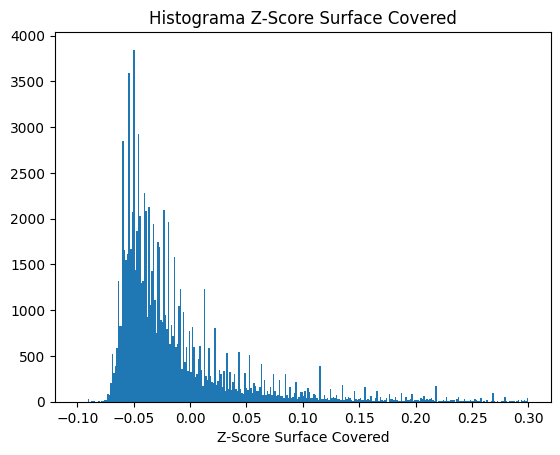

In [66]:
plt.hist(df.z_surface_covered, bins=300, range=(-0.1,0.3))
plt.title('Histograma Z-Score Surface Covered')
plt.xlabel('Z-Score Surface Covered')
plt.show()

##### Z-Score Modificado

In [67]:
mediana_surface_covered=np.nanmedian(df.property_surface_covered)
MAD=np.nanmedian(np.absolute(df.property_surface_covered-mediana_surface_covered))

df['zm_surface_covered']=(df.property_surface_covered - mediana_surface_covered)*0.6745/MAD

Estudiamos si existen datos para el método de Z-Score Modificado utilizando la regla de oro (|Z|>3.5).

In [68]:
df[(df['zm_surface_covered']>3.5)].head()

id start_date   end_date created_on    latitud  \
58   tgaK6Ibor1zLY5bvNxsXfw== 2021-09-09 2021-09-26 2021-09-09 -34.633730   
410  S8iZ1eflTJtt4bejzBVktw== 2021-09-09 2021-09-10 2021-09-09 -34.576741   
411  FblpEe26U1lQkU5vRzAtmg== 2021-09-09 2021-09-09 2021-09-09 -34.576741   
438  taPk4LSPMT26ftJm7/Bh6Q== 2021-09-09 2022-03-06 2021-09-09 -34.575053   
448  0Ui0Bm9reiNrJFdUfgXwiA== 2021-09-09 2022-01-27 2021-09-09 -34.577855   

      longitud         place_l2 place_l3       place_l4 property_type  ...  \
58  -58.424729  Capital Federal    Boedo          Boedo          Casa  ...   
410 -58.404830  Capital Federal  Palermo  Palermo Chico  Departamento  ...   
411 -58.404830  Capital Federal  Palermo  Palermo Chico  Departamento  ...   
438 -58.407958  Capital Federal  Palermo  Palermo Chico  Departamento  ...   
448 -58.408796  Capital Federal  Palermo  Palermo Chico  Departamento  ...   

     property_surface_covered  property_price   z_rooms  zm_rooms  z_bedrooms  \
58                      244.0        500000.0  4.992871    4.7215    7.237343   
410                     400.0       2700000.0  1.510104    1.3490    1.867914   
411                     400.0       2700000.0  1.510104    1.3490    1.867914   
438                     256.0       2250000.0  0.813550    0.6745    0.973010   
448                     294.0       1200000.0  1.510104    1.3490    1.867914   

     zm_bedrooms   z_price   zm_price  z_surface_covered  zm_surface_covered  
58        5.3960  0.859260   4.141197           0.160041             6.27285  
410       1.3490  7.764431  29.725680           0.320291            11.53395  
411       1.3490  7.764431  29.725680           0.320291            11.53395  
438       0.6745  6.352010  24.492491           0.172368             6.67755  
448       1.3490  3.056360  12.281715           0.211403             7.95910  

[5 rows x 23 columns]

In [69]:
df[(df['zm_surface_covered']<-3.5)].head()

Empty DataFrame
Columns: [id, start_date, end_date, created_on, latitud, longitud, place_l2, place_l3, place_l4, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price, z_rooms, zm_rooms, z_bedrooms, zm_bedrooms, z_price, zm_price, z_surface_covered, zm_surface_covered]
Index: []

[0 rows x 23 columns]

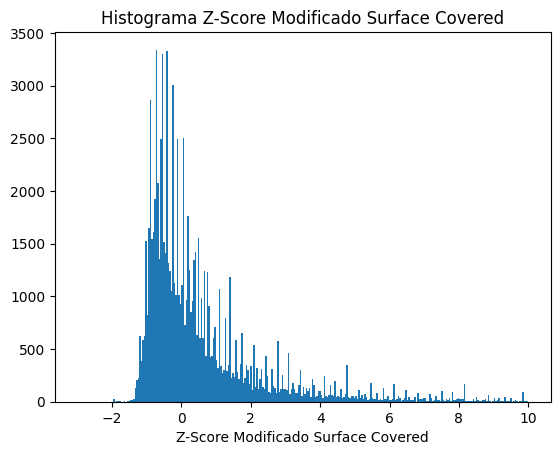

In [70]:
plt.hist(df.zm_surface_covered, bins=300, range=(-3,10))
plt.title('Histograma Z-Score Modificado Surface Covered')
plt.xlabel('Z-Score Modificado Surface Covered')
plt.show()

##### Características

Nuevamente, concluimos que al existir una gran masa conjunta de observaciones atípicas y una singular -también atípica- lejana a la masa en cuestión- podríamos decir que los outliers son del tipo colectivo (para la masa de observaciones cerca del máximo para el tercer cuartil) y global (para la observación singular por encima del resto de las observaciones).

#### Property surface total

##### Box plot

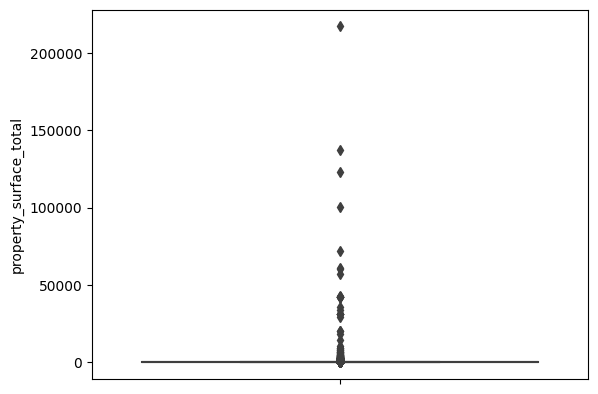

In [71]:
sns.boxplot(y=df.property_surface_total)
plt.show()

In [72]:
Q1_property_surface_total=df.describe().get("property_surface_total").get("25%")
Q3_property_surface_total=df.describe().get("property_surface_total").get("75%")

print("El valor de Q1 es:", Q1_property_surface_total)
print("El valor de Q3 es:", Q3_property_surface_total)

IQR_property_surface_total=Q3_property_surface_total-Q1_property_surface_total

out_inf=Q1_property_surface_total-1.5*IQR_property_surface_total
out_sup=Q3_property_surface_total+1.5*IQR_property_surface_total
print("El limite inferior del Q1 es:", out_inf)
print("El limite superior del Q3 es:", out_sup)

El valor de Q1 es: 45.0
El valor de Q3 es: 104.0
El limite inferior del Q1 es: -43.5
El limite superior del Q3 es: 192.5


##### Z-Score

In [73]:
media_surface_total=np.mean(df.property_surface_total)
std_surface_total=np.std(df.property_surface_total)
df['z_surface_total']=(df.property_surface_total - media_surface_total)/std_surface_total

Estudiamos si existen datos para el método de Z-Score utilizando la regla de oro (|Z|>3).

In [74]:
df[df['z_surface_total']>3].head()

id start_date   end_date created_on    latitud  \
1140   ddV7Ll5c1H+Rmqqovc+uFg== 2021-09-09 2022-01-27 2021-09-09 -34.605781   
1932   eQ/SiyES/mXWsSyAzb3k3A== 2021-12-17        NaT 2021-12-17 -34.637026   
33017  UzV402bMqMRezkA/xEyQ1w== 2021-02-08        NaT 2021-02-08 -34.634196   
34123  Kr2fYXhFuQz9vuxKD2btYw== 2021-02-08 2021-05-01 2021-02-08 -34.557903   
72316  BPTyNzwU2D4btCduu8ls3A== 2021-05-29 2021-06-08 2021-05-29 -34.578917   

        longitud         place_l2          place_l3          place_l4  \
1140  -58.376705  Capital Federal       San Nicolás       San Nicolás   
1932  -58.426283  Capital Federal  Parque Chacabuco  Parque Chacabuco   
33017 -58.465152  Capital Federal            Flores            Flores   
34123 -58.452293  Capital Federal          Belgrano          Belgrano   
72316 -58.429373  Capital Federal           Palermo           Palermo   

      property_type  ...  property_price   z_rooms  zm_rooms  z_bedrooms  \
1140   Departamento  ...       9900000.0       NaN       NaN         NaN   
1932           Casa  ...        250000.0       NaN       NaN         NaN   
33017  Departamento  ...         58552.0 -1.276110   -1.3490    -0.81680   
34123  Departamento  ...        418000.0  0.813550    0.6745     0.97301   
72316  Departamento  ...        225000.0 -0.579557   -0.6745    -0.81680   

       zm_bedrooms    z_price    zm_price  z_surface_covered  \
1140           NaN  30.363174  113.456715          10.695485   
1932           NaN   0.074581    1.233870         222.821967   
33017      -0.6745  -0.526319   -0.992538          -0.058763   
34123       0.6745   0.601885    3.187594           0.021362   
72316      -0.6745  -0.003886    0.943137          54.384295   

       zm_surface_covered  z_surface_total  
1140           352.156450         8.745611  
1932          7316.368950       182.568661  
33017           -0.910575         3.634455  
34123            1.719975         4.115941  
72316         1786.480700        51.363824  

[5 rows x 24 columns]

In [75]:
df[df['z_surface_total']<-3].head()

Empty DataFrame
Columns: [id, start_date, end_date, created_on, latitud, longitud, place_l2, place_l3, place_l4, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price, z_rooms, zm_rooms, z_bedrooms, zm_bedrooms, z_price, zm_price, z_surface_covered, zm_surface_covered, z_surface_total]
Index: []

[0 rows x 24 columns]

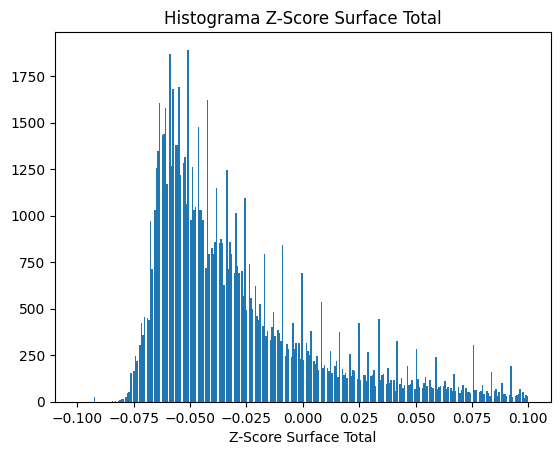

In [76]:
plt.hist(df.z_surface_total, bins=300, range=(-0.1,0.1))
plt.title('Histograma Z-Score Surface Total')
plt.xlabel('Z-Score Surface Total')
plt.show()

##### Z-Score Modificado

In [77]:
mediana_surface_total=np.nanmedian(df.property_surface_total)
MAD=np.nanmedian(np.absolute(df.property_surface_total-mediana_surface_total))

df['zm_surface_total']=(df.property_surface_total - mediana_surface_total)*0.6745/MAD

Estudiamos si existen datos para el método de Z-Score Modificado utilizando la regla de oro (|Z|>3.5).

In [78]:
df[(df['zm_surface_total']>3.5)].head()

id start_date   end_date created_on    latitud  \
58   tgaK6Ibor1zLY5bvNxsXfw== 2021-09-09 2021-09-26 2021-09-09 -34.633730   
410  S8iZ1eflTJtt4bejzBVktw== 2021-09-09 2021-09-10 2021-09-09 -34.576741   
411  FblpEe26U1lQkU5vRzAtmg== 2021-09-09 2021-09-09 2021-09-09 -34.576741   
438  taPk4LSPMT26ftJm7/Bh6Q== 2021-09-09 2022-03-06 2021-09-09 -34.575053   
448  0Ui0Bm9reiNrJFdUfgXwiA== 2021-09-09 2022-01-27 2021-09-09 -34.577855   

      longitud         place_l2 place_l3       place_l4 property_type  ...  \
58  -58.424729  Capital Federal    Boedo          Boedo          Casa  ...   
410 -58.404830  Capital Federal  Palermo  Palermo Chico  Departamento  ...   
411 -58.404830  Capital Federal  Palermo  Palermo Chico  Departamento  ...   
438 -58.407958  Capital Federal  Palermo  Palermo Chico  Departamento  ...   
448 -58.408796  Capital Federal  Palermo  Palermo Chico  Departamento  ...   

      z_rooms  zm_rooms  z_bedrooms  zm_bedrooms   z_price   zm_price  \
58   4.992871    4.7215    7.237343       5.3960  0.859260   4.141197   
410  1.510104    1.3490    1.867914       1.3490  7.764431  29.725680   
411  1.510104    1.3490    1.867914       1.3490  7.764431  29.725680   
438  0.813550    0.6745    0.973010       0.6745  6.352010  24.492491   
448  1.510104    1.3490    1.867914       1.3490  3.056360  12.281715   

     z_surface_covered  zm_surface_covered  z_surface_total  zm_surface_total  
58            0.160041             6.27285         0.238803           8.87642  
410           0.320291            11.53395         0.243854           9.03830  
411           0.320291            11.53395         0.243854           9.03830  
438           0.172368             6.67755         0.144526           5.85466  
448           0.211403             7.95910         0.163045           6.44822  

[5 rows x 25 columns]

In [79]:
df[(df['zm_surface_total']<-3.5)].head()

Empty DataFrame
Columns: [id, start_date, end_date, created_on, latitud, longitud, place_l2, place_l3, place_l4, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price, z_rooms, zm_rooms, z_bedrooms, zm_bedrooms, z_price, zm_price, z_surface_covered, zm_surface_covered, z_surface_total, zm_surface_total]
Index: []

[0 rows x 25 columns]

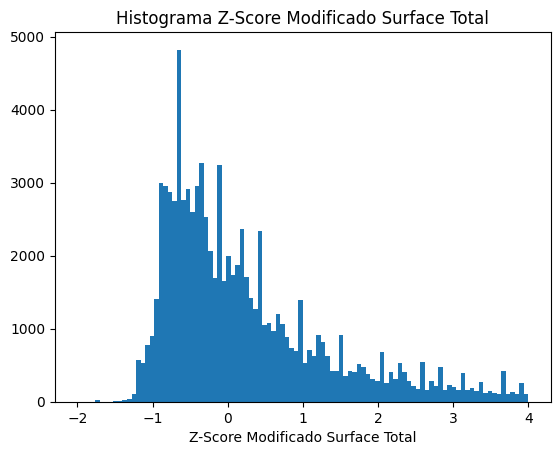

In [80]:
plt.hist(df.zm_surface_total, bins=100, range=(-2,4))
plt.title('Histograma Z-Score Modificado Surface Total')
plt.xlabel('Z-Score Modificado Surface Total')
plt.show()

##### Características

Nuevamente, concluimos que al existir una gran masa conjunta de observaciones atípicas y una singular -también atípica- lejana a la masa en cuestión- podríamos decir que los outliers son del tipo colectivo (para la masa de observaciones cerca del máximo para el tercer cuartil) y global (para la observación singular por encima del resto de las observaciones).

### Outliers multivariados

---

Para el análisis de outliers de tipo multivariados estaremos utilizando el método de Mahalanobis el cual nos brinda información respecto de la distancia de las observaciones agrupando las similares en clusters, evidenciando así los puntos aislados que pasaremos a considerar como valores atípicos.

Por último, podremos destacar cuáles son las características de los valores en cuestión pudiendo clasificar los mismos en: global, contextual y colectivo.

#### Preparación del dataset para el estudio de Mahalanobis

Para la utilización del método, analizamos la presencia de valores `nan` en nuestro dataset y analizamos la posibilidad de descartar los mismos en caso de existir nulos.

In [81]:
mahal = df.copy()
mahal.isnull().sum()

id                             0
start_date                     0
end_date                    5041
created_on                     0
latitud                        0
longitud                       0
place_l2                       0
place_l3                       0
place_l4                       0
property_type                  0
property_rooms               432
property_bedrooms            433
property_surface_total         0
property_surface_covered       0
property_price                 0
z_rooms                      432
zm_rooms                     432
z_bedrooms                   433
zm_bedrooms                  433
z_price                        0
zm_price                       0
z_surface_covered              0
zm_surface_covered             0
z_surface_total                0
zm_surface_total               0
dtype: int64

Procedemos a eliminar los registros en cuestión dado que representan una pequeña porción del dataset y no se verán afectados los resultados.

In [82]:
mahal.dropna(subset=['property_rooms', 'property_bedrooms'], inplace = True)
mahal.isnull().sum()

id                             0
start_date                     0
end_date                    5005
created_on                     0
latitud                        0
longitud                       0
place_l2                       0
place_l3                       0
place_l4                       0
property_type                  0
property_rooms                 0
property_bedrooms              0
property_surface_total         0
property_surface_covered       0
property_price                 0
z_rooms                        0
zm_rooms                       0
z_bedrooms                     0
zm_bedrooms                    0
z_price                        0
zm_price                       0
z_surface_covered              0
zm_surface_covered             0
z_surface_total                0
zm_surface_total               0
dtype: int64

#### Property surface total vs Price



##### Scatter


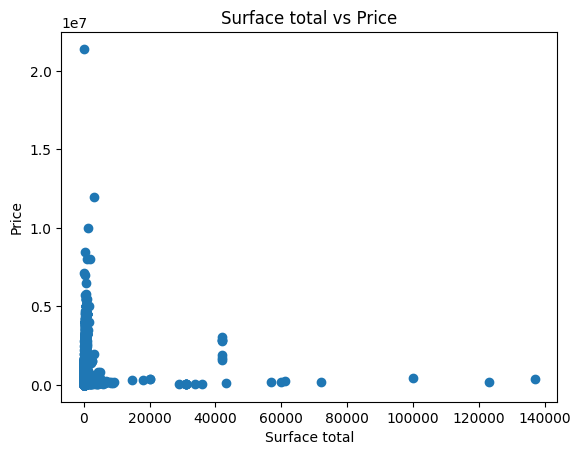

In [83]:
plt.scatter(mahal.property_surface_total,mahal.property_price)
plt.title('Surface total vs Price')
plt.xlabel('Surface total')
plt.ylabel('Price')
plt.show()

##### Mahalanobis

In [84]:
X = mahal[['property_surface_total','property_price']]
sample_X = X.sample(frac=0.1)

mu = sample_X.mean()
X_diff = X - mu
X_diff = X_diff.values.T

cov = np.cov(sample_X.values.T)
inv_cov = np.linalg.inv(cov)
W = sc.linalg.sqrtm(inv_cov)

Wx = np.matmul(W, X_diff)

mahal['mahal_sfto_prc'] = np.array([np.dot(Wx[:, i], Wx[:, i]) for i in range(Wx.shape[1])])

mahal.head()

id start_date   end_date created_on    latitud  \
25  CyZu6IaZgmQYGk8jmPajCg== 2021-09-09 2021-09-26 2021-09-09 -32.966425   
42  d3Z0MblSb2IMBoOBMGJEEQ== 2021-09-09 2021-09-26 2021-09-09 -34.637319   
43  rL7qPkQnomsMGu2ViS3sBw== 2021-09-09 2021-09-28 2021-09-09 -34.628647   
49  vuX/ccLAMVml4qWRFcOJUA== 2021-09-09 2022-01-05 2021-09-09 -34.610027   
51  ZTtSCeqZ3HUgf5jjwEzRcw== 2021-09-09 2022-03-09 2021-09-09 -34.631621   

     longitud         place_l2         place_l3         place_l4  \
25 -60.857846  Capital Federal  Capital Federal  Capital Federal   
42 -58.361124  Capital Federal             Boca             Boca   
43 -58.361871  Capital Federal             Boca             Boca   
49 -58.401934  Capital Federal             Once             Once   
51 -58.416825  Capital Federal            Boedo            Boedo   

   property_type  ...  zm_rooms  z_bedrooms  zm_bedrooms   z_price  zm_price  \
25          Casa  ...    0.6745    0.973010       0.6745 -0.050967  0.768697   
42  Departamento  ...    0.0000    0.078105       0.0000 -0.449898 -0.709388   
43  Departamento  ...    0.6745    0.973010       0.6745 -0.399364 -0.522156   
49  Departamento  ...    0.6745    0.078105       0.0000 -0.251845  0.024422   
51            PH  ...    0.6745    0.078105       0.0000  0.074581  1.233870   

    z_surface_covered  zm_surface_covered  z_surface_total  zm_surface_total  \
25           0.046016            2.529375         0.051091           2.85988   
42          -0.034109           -0.101175        -0.044028          -0.18886   
43          -0.018700            0.404700        -0.033927           0.13490   
49           0.016226            1.551350        -0.005307           1.05222   
51          -0.015619            0.505875        -0.031401           0.21584   

    mahal_sfto_prc  
25        0.014008  
42        0.212738  
43        0.168096  
49        0.068977  
51        0.008080  

[5 rows x 26 columns]

In [85]:
np.sort(mahal.mahal_sfto_prc)

array([1.44475451e-07, 2.84222302e-06, 8.47858252e-06, ...,
       2.28440465e+04, 3.45670555e+04, 4.28571833e+04])

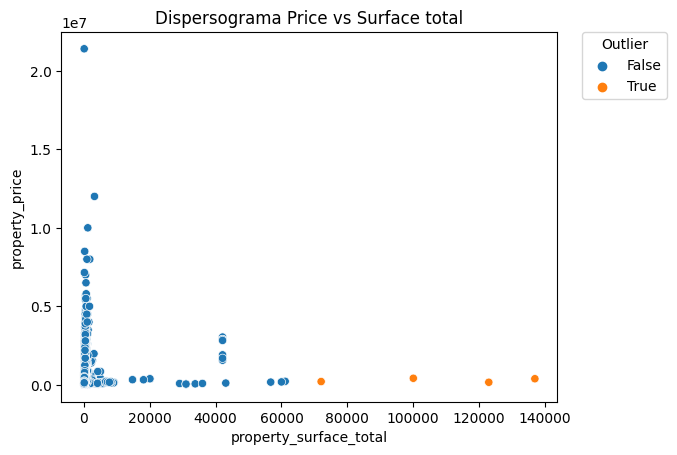

In [157]:
umbral=10000
mahal[mahal['mahal_sfto_prc']>umbral]

es_outlier = (mahal['mahal_sfto_prc'] > umbral)
sns.scatterplot(x=mahal.property_surface_total,y=mahal.property_price, hue=es_outlier)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title="Outlier")
plt.title('Dispersograma Price vs Surface total')
plt.show()

##### Caracteristicas

Podemos visualizar que los valores que se encuentran particularmente alejados de la masa de observaciones caben dentro de la clasificación de outliers globales.

#### Property rooms vs Property bedrooms

##### Scatter

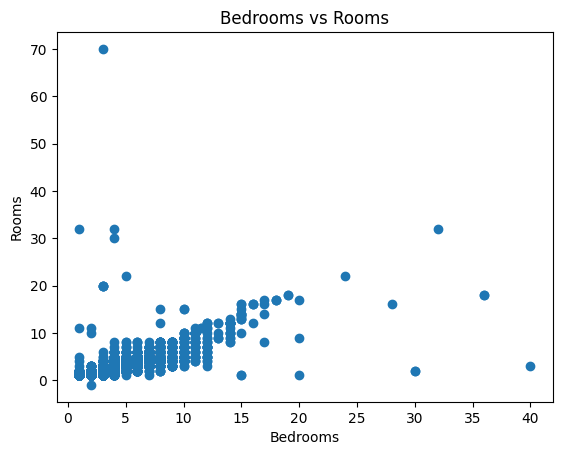

In [87]:
plt.scatter(mahal.property_rooms,mahal.property_bedrooms)
plt.title('Bedrooms vs Rooms')
plt.xlabel('Bedrooms')
plt.ylabel('Rooms')
plt.show()

##### Mahalanobis

In [88]:
X = mahal[['property_rooms','property_bedrooms']]
sample_X = X.sample(frac=0.1)

mu = sample_X.mean()
X_diff = X - mu
X_diff = X_diff.values.T

cov = np.cov(sample_X.values.T)
inv_cov = np.linalg.inv(cov)
W = sc.linalg.sqrtm(inv_cov)

Wx = np.matmul(W, X_diff)

mahal['mahal_ro_bdro'] = np.array([np.dot(Wx[:, i], Wx[:, i]) for i in range(Wx.shape[1])])

mahal.head()

id start_date   end_date created_on    latitud  \
25  CyZu6IaZgmQYGk8jmPajCg== 2021-09-09 2021-09-26 2021-09-09 -32.966425   
42  d3Z0MblSb2IMBoOBMGJEEQ== 2021-09-09 2021-09-26 2021-09-09 -34.637319   
43  rL7qPkQnomsMGu2ViS3sBw== 2021-09-09 2021-09-28 2021-09-09 -34.628647   
49  vuX/ccLAMVml4qWRFcOJUA== 2021-09-09 2022-01-05 2021-09-09 -34.610027   
51  ZTtSCeqZ3HUgf5jjwEzRcw== 2021-09-09 2022-03-09 2021-09-09 -34.631621   

     longitud         place_l2         place_l3         place_l4  \
25 -60.857846  Capital Federal  Capital Federal  Capital Federal   
42 -58.361124  Capital Federal             Boca             Boca   
43 -58.361871  Capital Federal             Boca             Boca   
49 -58.401934  Capital Federal             Once             Once   
51 -58.416825  Capital Federal            Boedo            Boedo   

   property_type  ...  z_bedrooms  zm_bedrooms   z_price  zm_price  \
25          Casa  ...    0.973010       0.6745 -0.050967  0.768697   
42  Departamento  ...    0.078105       0.0000 -0.449898 -0.709388   
43  Departamento  ...    0.973010       0.6745 -0.399364 -0.522156   
49  Departamento  ...    0.078105       0.0000 -0.251845  0.024422   
51            PH  ...    0.078105       0.0000  0.074581  1.233870   

    z_surface_covered  zm_surface_covered  z_surface_total  zm_surface_total  \
25           0.046016            2.529375         0.051091           2.85988   
42          -0.034109           -0.101175        -0.044028          -0.18886   
43          -0.018700            0.404700        -0.033927           0.13490   
49           0.016226            1.551350        -0.005307           1.05222   
51          -0.015619            0.505875        -0.031401           0.21584   

    mahal_sfto_prc  mahal_ro_bdro  
25        0.014008       0.854644  
42        0.212738       0.015852  
43        0.168096       0.854644  
49        0.068977       1.996158  
51        0.008080       1.996158  

[5 rows x 27 columns]

In [89]:
np.sort(mahal.mahal_ro_bdro)

array([1.58515271e-02, 1.58515271e-02, 1.58515271e-02, ...,
       2.21888928e+03, 2.44561094e+03, 1.14786613e+04])

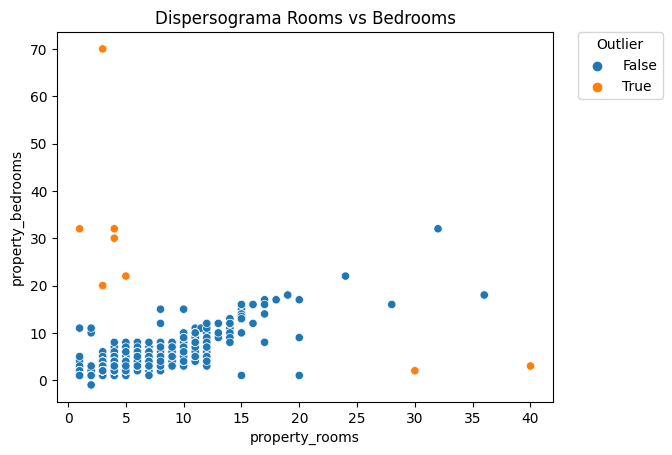

In [90]:
umbral=700
mahal[mahal['mahal_ro_bdro']>umbral]

es_outlier = (mahal['mahal_ro_bdro'] > umbral)

sns.scatterplot(x=mahal.property_rooms,y=mahal.property_bedrooms, hue=es_outlier)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title="Outlier")
plt.title('Dispersograma Rooms vs Bedrooms')
plt.show()

##### Caracteristicas

Notamos que estamos en presencia de outliers en su mayoría globales, con la particularidad de que tenemos algunos casos de valores atípicos colectivos en las cercanías del rango equivalente a 30 respecto del eje `property_bedrooms`.

Adicionalmente, cabe destacar que hay dos valores particularmente alejados. Siguiendo esta línea, llegamos a la conclusión de que estamos en presencia de outliers globales.

#### Property rooms vs Property surface total

##### Scatter


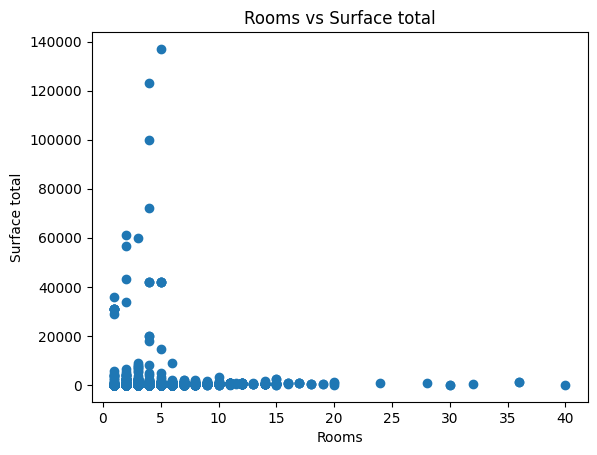

In [91]:
plt.scatter(mahal.property_rooms,mahal.property_surface_total)
plt.title('Rooms vs Surface total')
plt.xlabel('Rooms')
plt.ylabel('Surface total')
plt.show()

##### Mahalanobis

Para poder determinar concretamente estos valores atipicos, nos ayudamos con el calculo de la distancia de mahalanobis para cada una de las observaciones presentes.

In [92]:
X = mahal[['property_rooms','property_surface_total']]
sample_X = X.sample(frac=0.1)

mu = sample_X.mean()
X_diff = X - mu
X_diff = X_diff.values.T

cov = np.cov(sample_X.values.T)
inv_cov = np.linalg.inv(cov)
W = sc.linalg.sqrtm(inv_cov)

Wx = np.matmul(W, X_diff)

mahal['mahal_ro_sfto'] = np.array([np.dot(Wx[:, i], Wx[:, i]) for i in range(Wx.shape[1])])

mahal.head()

id start_date   end_date created_on    latitud  \
25  CyZu6IaZgmQYGk8jmPajCg== 2021-09-09 2021-09-26 2021-09-09 -32.966425   
42  d3Z0MblSb2IMBoOBMGJEEQ== 2021-09-09 2021-09-26 2021-09-09 -34.637319   
43  rL7qPkQnomsMGu2ViS3sBw== 2021-09-09 2021-09-28 2021-09-09 -34.628647   
49  vuX/ccLAMVml4qWRFcOJUA== 2021-09-09 2022-01-05 2021-09-09 -34.610027   
51  ZTtSCeqZ3HUgf5jjwEzRcw== 2021-09-09 2022-03-09 2021-09-09 -34.631621   

     longitud         place_l2         place_l3         place_l4  \
25 -60.857846  Capital Federal  Capital Federal  Capital Federal   
42 -58.361124  Capital Federal             Boca             Boca   
43 -58.361871  Capital Federal             Boca             Boca   
49 -58.401934  Capital Federal             Once             Once   
51 -58.416825  Capital Federal            Boedo            Boedo   

   property_type  ...  zm_bedrooms   z_price  zm_price  z_surface_covered  \
25          Casa  ...       0.6745 -0.050967  0.768697           0.046016   
42  Departamento  ...       0.0000 -0.449898 -0.709388          -0.034109   
43  Departamento  ...       0.6745 -0.399364 -0.522156          -0.018700   
49  Departamento  ...       0.0000 -0.251845  0.024422           0.016226   
51            PH  ...       0.0000  0.074581  1.233870          -0.015619   

    zm_surface_covered  z_surface_total  zm_surface_total  mahal_sfto_prc  \
25            2.529375         0.051091           2.85988        0.014008   
42           -0.101175        -0.044028          -0.18886        0.212738   
43            0.404700        -0.033927           0.13490        0.168096   
49            1.551350        -0.005307           1.05222        0.068977   
51            0.505875        -0.031401           0.21584        0.008080   

    mahal_ro_bdro  mahal_ro_sfto  
25       0.854644       0.667585  
42       0.015852       0.017885  
43       0.854644       0.690382  
49       1.996158       0.676874  
51       1.996158       0.688952  

[5 rows x 28 columns]

In [93]:
np.sort(mahal.mahal_ro_sfto)

array([1.06715921e-02, 1.06715921e-02, 1.06715921e-02, ...,
       2.55606410e+04, 3.86415379e+04, 4.79157534e+04])

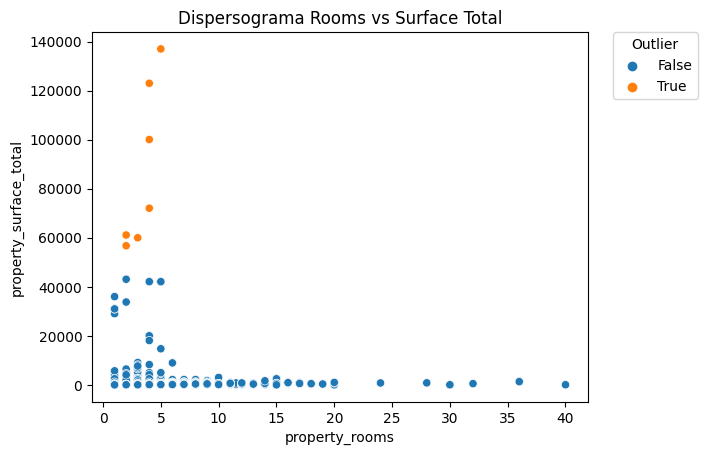

In [94]:
umbral=5000
mahal[mahal['mahal_ro_sfto']>umbral]

es_outlier = (mahal['mahal_ro_sfto'] > umbral)

sns.scatterplot(x=mahal.property_rooms,y=mahal.property_surface_total, hue=es_outlier)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title="Outlier")
plt.title('Dispersograma Rooms vs Surface Total')
plt.show()

##### Caracteristicas

En esta nueva comparación, contamos -una vez más- con la presencia de registros aislados en la parte superior izquierda que podríamos clasificarlos como outliers globales.

#### Property rooms vs Property surface covered

##### Scatter

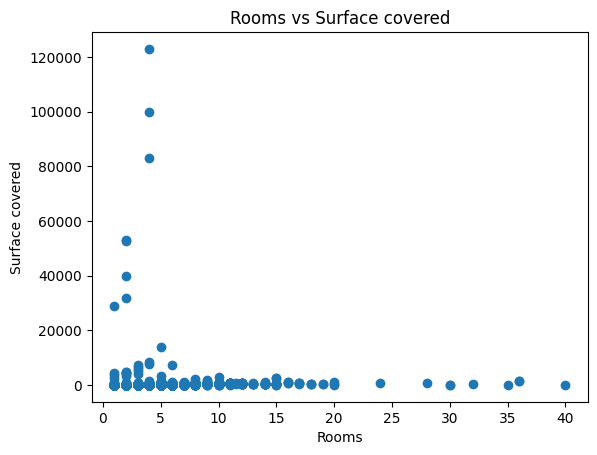

In [95]:
plt.scatter(df.property_rooms,df.property_surface_covered)
plt.title('Rooms vs Surface covered')
plt.xlabel('Rooms')
plt.ylabel('Surface covered')
plt.show()

##### Mahalanobis

In [96]:
X = mahal[['property_rooms','property_surface_covered']]
sample_X = X.sample(frac=0.1)

mu = sample_X.mean()
X_diff = X - mu
X_diff = X_diff.values.T

cov = np.cov(sample_X.values.T)
inv_cov = np.linalg.inv(cov)
W = sc.linalg.sqrtm(inv_cov)

Wx = np.matmul(W, X_diff)

mahal['mahal_ro_sfcv'] = np.array([np.dot(Wx[:, i], Wx[:, i]) for i in range(Wx.shape[1])])

mahal.head()

id start_date   end_date created_on    latitud  \
25  CyZu6IaZgmQYGk8jmPajCg== 2021-09-09 2021-09-26 2021-09-09 -32.966425   
42  d3Z0MblSb2IMBoOBMGJEEQ== 2021-09-09 2021-09-26 2021-09-09 -34.637319   
43  rL7qPkQnomsMGu2ViS3sBw== 2021-09-09 2021-09-28 2021-09-09 -34.628647   
49  vuX/ccLAMVml4qWRFcOJUA== 2021-09-09 2022-01-05 2021-09-09 -34.610027   
51  ZTtSCeqZ3HUgf5jjwEzRcw== 2021-09-09 2022-03-09 2021-09-09 -34.631621   

     longitud         place_l2         place_l3         place_l4  \
25 -60.857846  Capital Federal  Capital Federal  Capital Federal   
42 -58.361124  Capital Federal             Boca             Boca   
43 -58.361871  Capital Federal             Boca             Boca   
49 -58.401934  Capital Federal             Once             Once   
51 -58.416825  Capital Federal            Boedo            Boedo   

   property_type  ...   z_price  zm_price  z_surface_covered  \
25          Casa  ... -0.050967  0.768697           0.046016   
42  Departamento  ... -0.449898 -0.709388          -0.034109   
43  Departamento  ... -0.399364 -0.522156          -0.018700   
49  Departamento  ... -0.251845  0.024422           0.016226   
51            PH  ...  0.074581  1.233870          -0.015619   

    zm_surface_covered  z_surface_total  zm_surface_total  mahal_sfto_prc  \
25            2.529375         0.051091           2.85988        0.014008   
42           -0.101175        -0.044028          -0.18886        0.212738   
43            0.404700        -0.033927           0.13490        0.168096   
49            1.551350        -0.005307           1.05222        0.068977   
51            0.505875        -0.031401           0.21584        0.008080   

    mahal_ro_bdro  mahal_ro_sfto  mahal_ro_sfcv  
25       0.854644       0.667585       0.655304  
42       0.015852       0.017885       0.018143  
43       0.854644       0.690382       0.670699  
49       1.996158       0.676874       0.656668  
51       1.996158       0.688952       0.668921  

[5 rows x 29 columns]

In [97]:
np.sort(mahal.mahal_ro_sfcv)

array([1.14799190e-02, 1.14799190e-02, 1.14799190e-02, ...,
       3.98601306e+04, 5.79484791e+04, 8.76206491e+04])

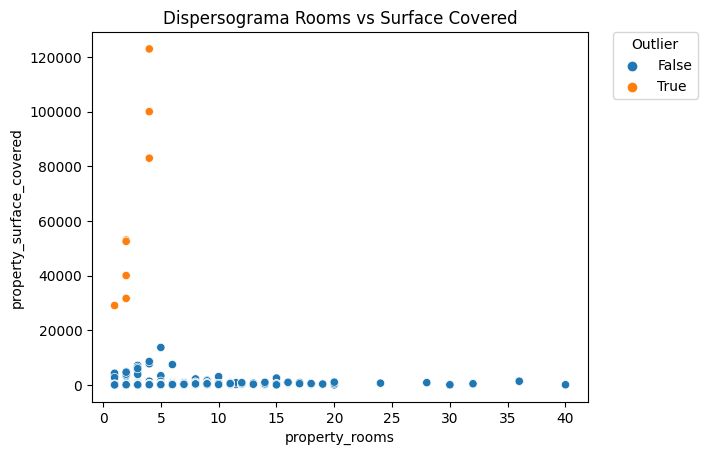

In [98]:
umbral=3000
mahal[mahal['mahal_ro_sfcv']>umbral]

es_outlier = (mahal['mahal_ro_sfcv'] > umbral)

sns.scatterplot(x=mahal.property_rooms,y=mahal.property_surface_covered, hue=es_outlier)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title="Outlier")
plt.title('Dispersograma Rooms vs Surface Covered')
plt.show()

##### Caracteristicas

Luego de la comparación de surface covered vs property rooms, notamos que nuevamente estamos en presencia de outliers, en particular esta vez todos de carácter global.


#### Property rooms vs Property price

##### Scatter

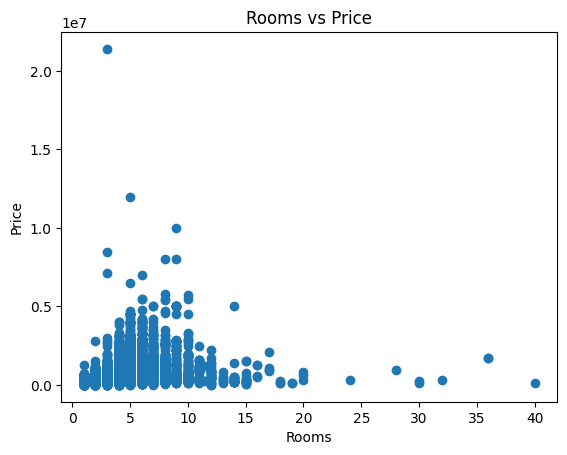

In [99]:
plt.scatter(mahal.property_rooms,mahal.property_price)
plt.title('Rooms vs Price')
plt.xlabel('Rooms')
plt.ylabel('Price')
plt.show()

##### Mahalanobis

In [100]:
X = mahal[['property_rooms','property_price']]
sample_X = X.sample(frac=0.1)

mu = sample_X.mean()
X_diff = X - mu
X_diff = X_diff.values.T

cov = np.cov(sample_X.values.T)
inv_cov = np.linalg.inv(cov)
W = sc.linalg.sqrtm(inv_cov)

Wx = np.matmul(W, X_diff)

mahal['mahal_ro_pr'] = np.array([np.dot(Wx[:, i], Wx[:, i]) for i in range(Wx.shape[1])])

mahal.head()

id start_date   end_date created_on    latitud  \
25  CyZu6IaZgmQYGk8jmPajCg== 2021-09-09 2021-09-26 2021-09-09 -32.966425   
42  d3Z0MblSb2IMBoOBMGJEEQ== 2021-09-09 2021-09-26 2021-09-09 -34.637319   
43  rL7qPkQnomsMGu2ViS3sBw== 2021-09-09 2021-09-28 2021-09-09 -34.628647   
49  vuX/ccLAMVml4qWRFcOJUA== 2021-09-09 2022-01-05 2021-09-09 -34.610027   
51  ZTtSCeqZ3HUgf5jjwEzRcw== 2021-09-09 2022-03-09 2021-09-09 -34.631621   

     longitud         place_l2         place_l3         place_l4  \
25 -60.857846  Capital Federal  Capital Federal  Capital Federal   
42 -58.361124  Capital Federal             Boca             Boca   
43 -58.361871  Capital Federal             Boca             Boca   
49 -58.401934  Capital Federal             Once             Once   
51 -58.416825  Capital Federal            Boedo            Boedo   

   property_type  ...  zm_price  z_surface_covered  zm_surface_covered  \
25          Casa  ...  0.768697           0.046016            2.529375   
42  Departamento  ... -0.709388          -0.034109           -0.101175   
43  Departamento  ... -0.522156          -0.018700            0.404700   
49  Departamento  ...  0.024422           0.016226            1.551350   
51            PH  ...  1.233870          -0.015619            0.505875   

    z_surface_total  zm_surface_total  mahal_sfto_prc  mahal_ro_bdro  \
25         0.051091           2.85988        0.014008       0.854644   
42        -0.044028          -0.18886        0.212738       0.015852   
43        -0.033927           0.13490        0.168096       0.854644   
49        -0.005307           1.05222        0.068977       1.996158   
51        -0.031401           0.21584        0.008080       1.996158   

    mahal_ro_sfto  mahal_ro_sfcv  mahal_ro_pr  
25       0.667585       0.655304     0.855728  
42       0.017885       0.018143     0.388224  
43       0.690382       0.670699     1.485215  
49       0.676874       0.656668     1.172937  
51       0.688952       0.668921     0.720727  

[5 rows x 30 columns]

In [101]:
np.sort(mahal.mahal_ro_pr)

array([1.01734393e-02, 1.01734393e-02, 1.01734424e-02, ...,
       1.29201295e+03, 2.03358197e+03, 6.80790887e+03])

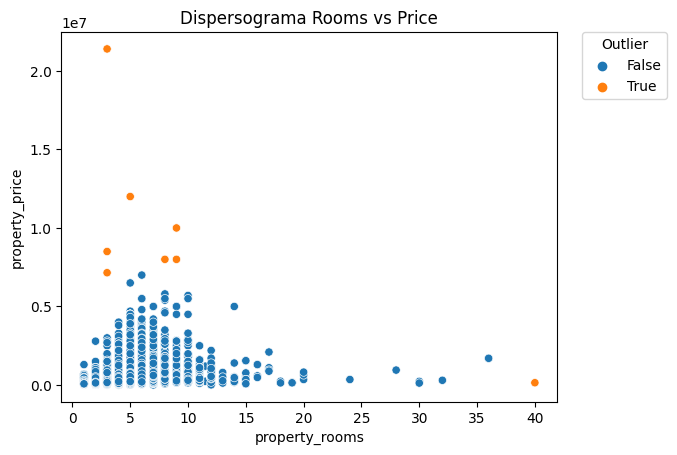

In [102]:
umbral=700
mahal[mahal['mahal_ro_pr']>umbral]

es_outlier = (mahal['mahal_ro_pr'] > umbral)

sns.scatterplot(x=mahal.property_rooms,y=mahal.property_price, hue=es_outlier)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title="Outlier")
plt.title('Dispersograma Rooms vs Price')
plt.show()

##### Caracteristicas

Nuevamente visualizamos outliers globales.

### Tratamiento

Para cada una de las variables, estudiamos si es posible eliminar los valores atípicos encontrados con los métodos previamente descriptos analizando la proporción que estos representan sobre el total de los valores, teniendo en cuenta la decisión de admitir una tolerancia del 10% de otuliers.

#### Property rooms

In [103]:
rooms_outliers_porcentaje = df[(df['zm_rooms']>3.5)].shape[0]/df['zm_rooms'].shape[0]*100

print(f"Los valores atípicos encontrados para property_rooms representan un {round(rooms_outliers_porcentaje, 3)}% del total del dataset.")

Los valores atípicos encontrados para property_rooms representan un 0.429% del total del dataset.


Eliminamos los outliers del dataset:

In [104]:
df.drop(df[df['zm_rooms']>3.5].index, inplace=True)

#### Property bedrooms

In [105]:
bedrooms_outliers_porcentaje = df[(df['zm_bedrooms']>3.5)].shape[0]/df['zm_bedrooms'].shape[0]*100

print(f"Los valores atípicos encontrados para property_bedrooms representan un {round(bedrooms_outliers_porcentaje, 3)}% del total del dataset.")

Los valores atípicos encontrados para property_bedrooms representan un 0.033% del total del dataset.


In [106]:
df.drop(df[df['zm_bedrooms']>3.5].index, inplace=True)

#### Property price

In [107]:
price_outliers_porcentaje = df[(df['zm_price']>3.5)].shape[0]/df['zm_price'].shape[0]*100

print(f"Los valores atípicos encontrados para property_price representan un {round(price_outliers_porcentaje, 3)}% del total del dataset.")

Los valores atípicos encontrados para property_price representan un 8.911% del total del dataset.


In [108]:
df.drop(df[df['zm_price']>3.5].index, inplace=True)

#### Property surface covered

In [109]:
surface_covered_outliers_porcentaje = df[(df['zm_surface_covered']>3.5)].shape[0]/df['zm_surface_covered'].shape[0]*100

print(f"Los valores atípicos encontrados para property_surface_covered representan un {round(surface_covered_outliers_porcentaje, 3)}% del total del dataset.")

Los valores atípicos encontrados para property_surface_covered representan un 2.724% del total del dataset.


In [110]:
df.drop(df[df['zm_surface_covered']>3.5].index, inplace=True)

#### Property surface total

In [111]:
surface_total_outliers_porcentaje = df[(df['zm_surface_total']>3.5)].shape[0]/df['zm_surface_total'].shape[0]*100

print(f"Los valores atípicos encontrados para property_surface_total representan un {round(surface_total_outliers_porcentaje, 3)}% del total del dataset.")

Los valores atípicos encontrados para property_surface_total representan un 1.442% del total del dataset.


In [112]:
df.drop(df[df['zm_surface_total']>3.5].index, inplace=True)

## **1d. Reducción de la dimensionalidad**

Para realizar la reducción de la dimensionalidad del dataset, estaremos utilizando el algoritmo PCA con el objetivo de reducir la dimensión del problema descartando la información redundante existente.

Generamos un nuevo dataset de reducción de dimensionalidad:

In [113]:
df_reduc = df.copy()

Antes de ejecutar el algoritmo, verificamos que no existan nulos para las variables de importancia que no brinden información de relevancia. En caso de existir, los eliminamos.

In [114]:
df_reduc.drop(df_reduc[df_reduc['property_rooms'].isna()].index, inplace=True)
df_reduc.drop(df_reduc[df_reduc['property_bedrooms'].isna()].index, inplace=True)
df_reduc.drop(df_reduc[df_reduc['property_price'].isna()].index, inplace=True)
df_reduc.drop(df_reduc[df_reduc['property_surface_covered'].isna()].index, inplace=True)
df_reduc.drop(df_reduc[df_reduc['property_surface_total'].isna()].index, inplace=True)

In [115]:
columnas_elegidas = ['property_rooms', 'property_bedrooms', 'property_price', 'property_surface_covered', 'property_surface_total']

x = df_reduc.loc[:, columnas_elegidas].values
x = StandardScaler().fit_transform(x)

In [116]:
pca = PCA(n_components=5)
x_transformada = pca.fit_transform(x)

pca_df_aux = pd.DataFrame(data = x_transformada
             , columns = ['cp_1', 'cp_2','cp_3','cp_4','cp_5'])

In [117]:
df_reduc['target'] = 0
target = pd.DataFrame((np.column_stack(df_reduc['target'])).tolist()).T
df_pca = pd.concat([pca_df_aux, target], axis = 1)
df_pca.columns= ['cp_1', 'cp_2','cp_3','cp_4', 'cp_5','target']
df_pca.head()

cp_1      cp_2      cp_3      cp_4      cp_5  target
0  4.317762  0.042507 -1.734132  0.233340  0.044888       0
1 -0.171887  1.058977 -0.020688 -0.067410 -0.067110       0
2  1.302619  1.816810  0.243172  0.118764 -0.105214       0
3  2.035326  0.471617 -0.883720 -0.648833 -0.544557       0
4  1.586724 -0.135328  0.845383 -0.715238 -0.118358       0

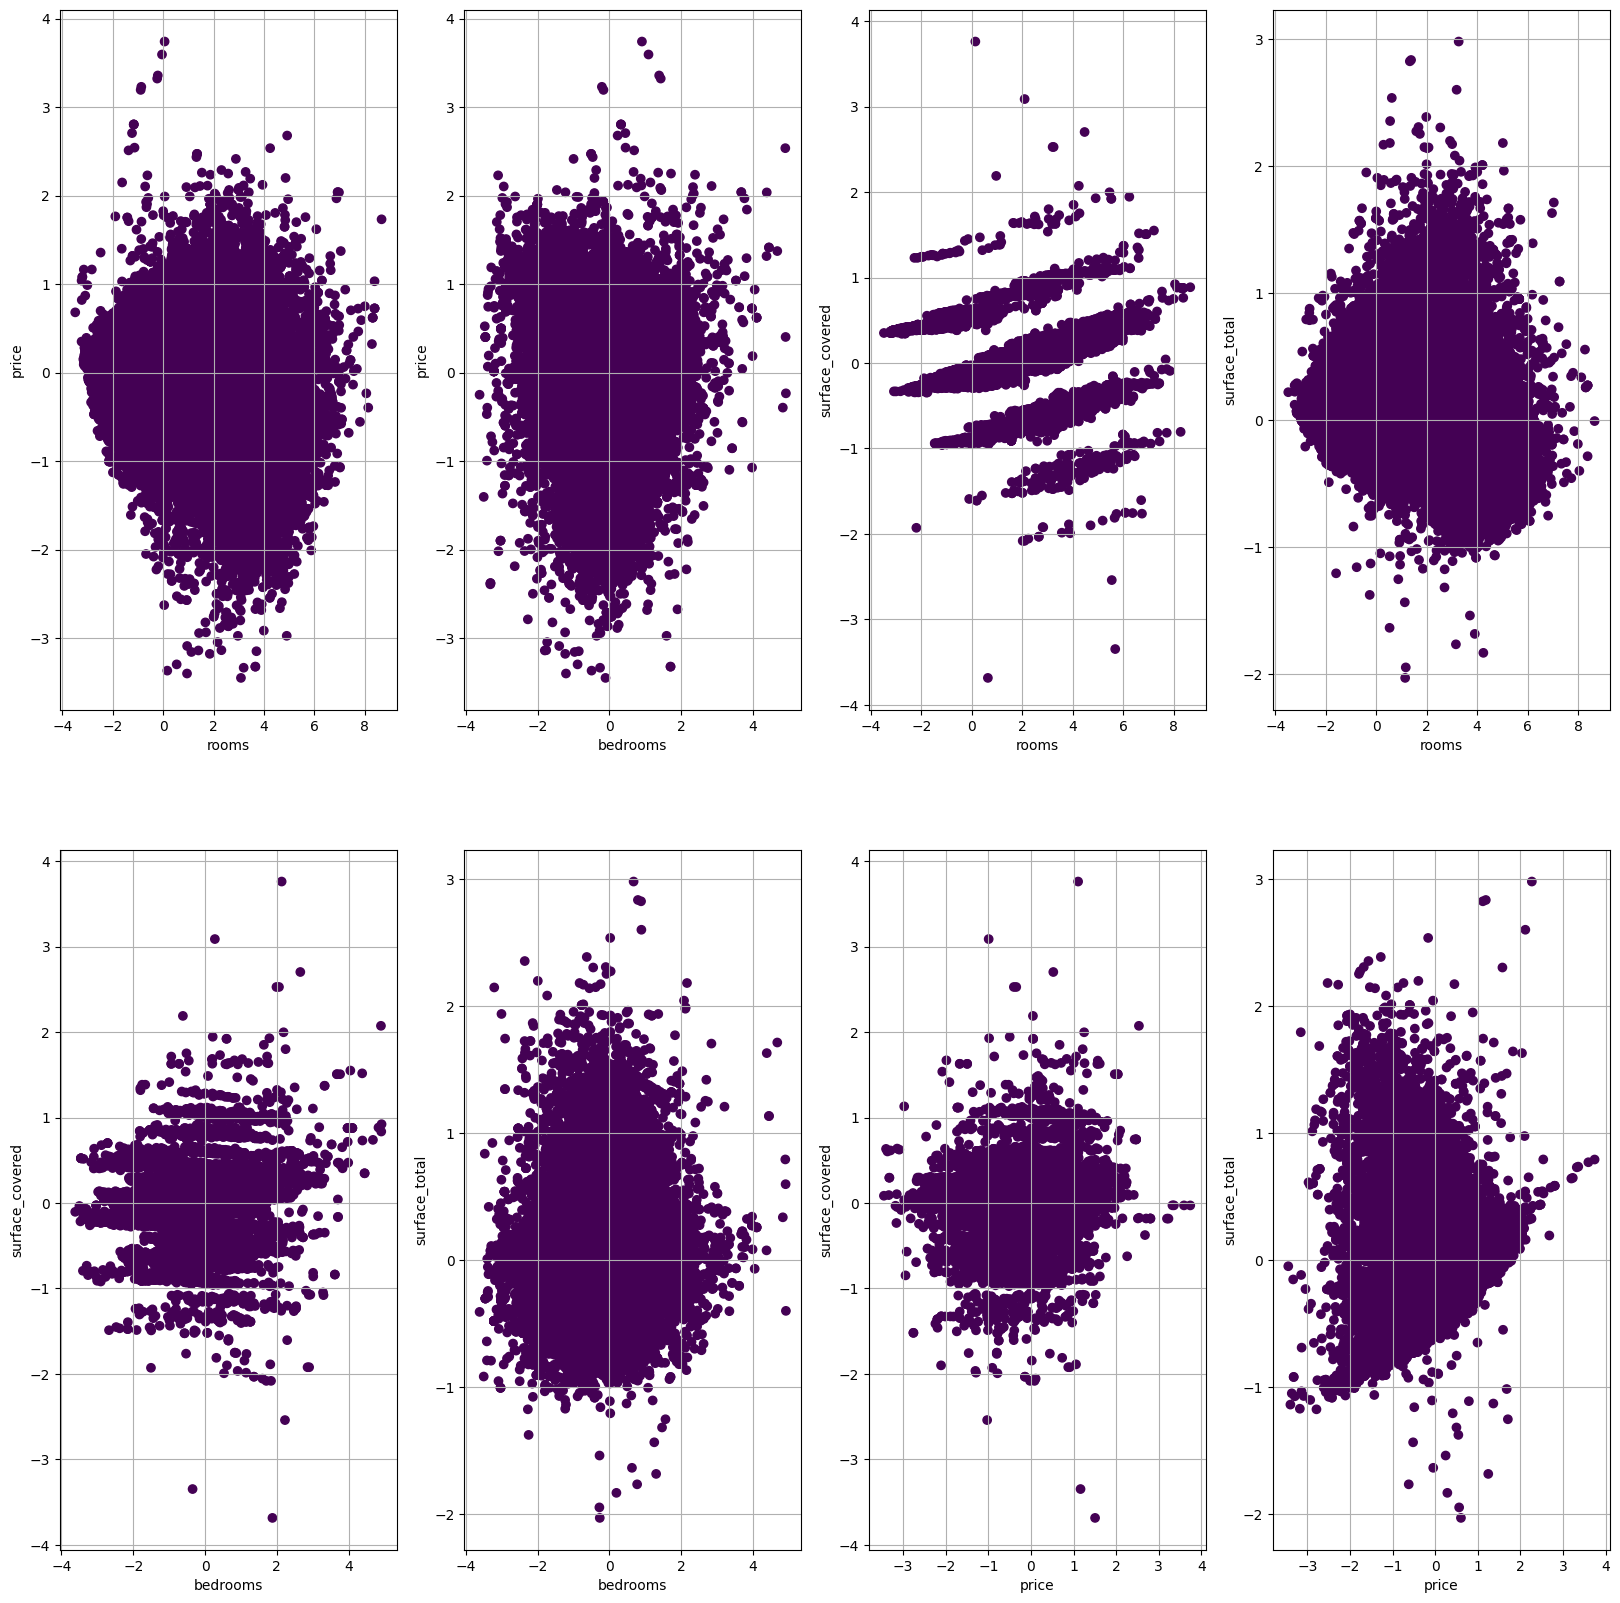

In [118]:
targets = ['Casa', 'PH', 'Departamento']

fig = plt.figure(figsize = (20,20))

c = df_pca['target']

## plot 1

ax = fig.add_subplot(2, 4, 1) 

x = df_pca['cp_1']
y = df_pca['cp_3']

ax.scatter(x = x, y = y, c = c)

ax.set_xlabel('rooms', fontsize = 10)
ax.set_ylabel('price', fontsize = 10)
ax.grid()

## plot 2

ax = fig.add_subplot(2, 4, 2) 

x = df_pca['cp_2']

ax.scatter(x = x, y = y, c = c)

ax.set_xlabel('bedrooms', fontsize = 10)
ax.set_ylabel('price', fontsize = 10)
ax.grid()

## plot 3

ax = fig.add_subplot(2, 4, 3) 

x = df_pca['cp_1']
y = df_pca['cp_4']

ax.scatter(x = x, y = y, c = c)

ax.set_xlabel('rooms', fontsize = 10)
ax.set_ylabel('surface_covered', fontsize = 10)
ax.grid()

## plot 4

ax = fig.add_subplot(2, 4, 4) 

y = df_pca['cp_5']

ax.scatter(x = x, y = y, c = c)

ax.set_xlabel('rooms', fontsize = 10)
ax.set_ylabel('surface_total', fontsize = 10)
ax.grid()

## plot 5

ax = fig.add_subplot(2, 4, 5) 

x = df_pca['cp_2']
y = df_pca['cp_4']

ax.scatter(x = x, y = y, c = c)

ax.set_xlabel('bedrooms', fontsize = 10)
ax.set_ylabel('surface_covered', fontsize = 10)
ax.grid()

## plot 6

ax = fig.add_subplot(2, 4, 6) 

y = df_pca['cp_5']

ax.scatter(x = x, y = y, c = c)

ax.set_xlabel('bedrooms', fontsize = 10)
ax.set_ylabel('surface_total', fontsize = 10)
ax.grid()

## plot 7

ax = fig.add_subplot(2, 4, 7) 

x = df_pca['cp_3']
y = df_pca['cp_4']

ax.scatter(x = x, y = y, c = c)

ax.set_xlabel('price', fontsize = 10)
ax.set_ylabel('surface_covered', fontsize = 10)
ax.grid()

## plot 8

ax = fig.add_subplot(2, 4, 8) 

y = df_pca['cp_5']

ax.scatter(x = x, y = y, c = c)

ax.set_xlabel('price', fontsize = 10)
ax.set_ylabel('surface_total', fontsize = 10)
ax.grid()

plt.show()

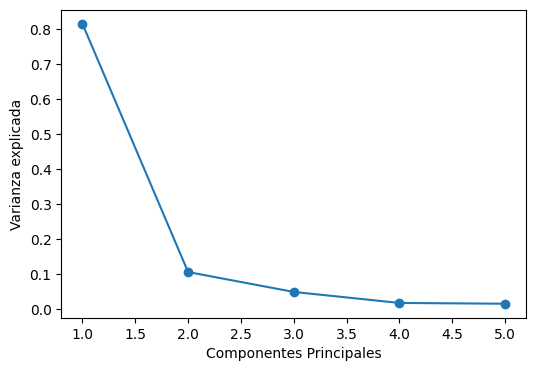

In [119]:
varianza_explicada = pca.explained_variance_ratio_
list_x = list(range(1, len(varianza_explicada)+1))

plt.figure(figsize=(6, 4))
plt.plot(list_x, varianza_explicada, '-o')
plt.xlabel(r'Componentes Principales')
plt.ylabel('Varianza explicada')
plt.show()

#  **2. Agrupamiento**

Primero removemos entradas del dataframe que contienen coordenadas fuera de CABA



In [120]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

CABA_lat = -34.611817
CABA_long = -58.446881

df = df.loc[((CABA_lat - 0.5) < df["latitud"]) & (df["latitud"] < (CABA_lat + 0.5))]
df = df.loc[((CABA_long - 0.5) < df["longitud"]) & (df["longitud"] < (CABA_long + 0.5))]

El primer análisis de clustering lo realizamos entre las variables longitud y latitud, viendo la tendencia al agrupamiento que existe en la posición geográfica:



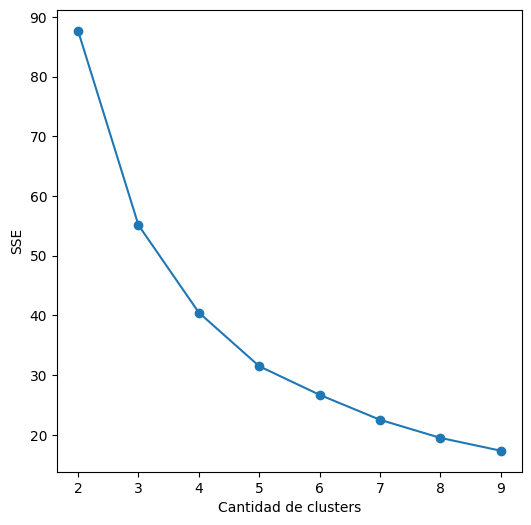

In [121]:
X = np.column_stack((df.longitud.tolist(), df.latitud.tolist()))

sse = []
list_k = list(range(2, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X)
    sse.append(km.inertia_)
    
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Cantidad de clusters')
plt.ylabel('SSE')
plt.show()

Utilizando 5 clusters



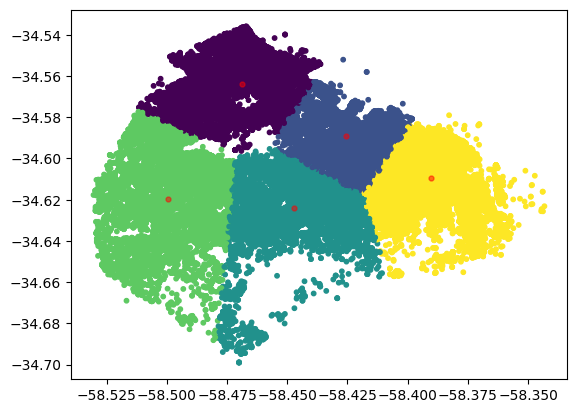

KeyboardInterrupt: 

In [122]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=10)

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=50, alpha=0.5,marker='.')
plt.show()
print ("Silhouette Score para 5 clusters = " + str(silhouette_score(X, y_kmeans)))

Utilizando 3 clusters



In [ ]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=10)

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=50, alpha=0.5,marker='.')
plt.show()

print ("Silhouette Score para 3 clusters = " + str(silhouette_score(X, y_kmeans)))

Viendo la curva de cantidad de clusters contra la distancia media al centroide (SSE) podemos ver que no existen clusters definidos, no se ve un claro codo en el cual elegir un numero de clusters ideal. No existen agrupamientos definidos.

Un segundo análisis que decidimos realizar es si existe clustering entre tres variables: longitud, latitud y precio. Obtuvimos los mismos resultados que el caso anterior:

In [ ]:
X = df.iloc[:,[5,4,15]].values

sse = []
list_k = list(range(2, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X)
    sse.append(km.inertia_)
    
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Cantidad de clusters')
plt.ylabel('SSE')
plt.show()

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')

kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

centers = kmeans.cluster_centers_
ax.scatter(X[:,0], X[:,1], X[:,2], c=y_kmeans, s=0.2)
ax.scatter(centers[:,0], centers[:,1], centers[:,2], c="red", s=500, marker="o")

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=1)


Como no obtuvimos un clustering definido, buscamos ver si existía un agrupamiento entre ubicación geográfica y precio por metro cuadrado. Los resultados fueron similares.

In [ ]:
df["property_m2price"] = df["property_price"] / df["property_surface_total"]
X = df.iloc[:,[5,4, df.shape[1]-1]].loc[(df.property_m2price < 5000)].values
sse = []
sscore = []
list_k = list(range(2, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X)
    y_kmeans = km.predict(X)
    sse.append(km.inertia_)
    sscore.append(silhouette_score(X, y_kmeans))
    
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Cantidad de clusters')
plt.ylabel('SSE')
plt.show()

In [ ]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')

kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
ax.scatter(X[:,0], X[:,1], X[:,2], c=y_kmeans, s=5)

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=10)


In [ ]:
plt.figure(figsize=(6, 6))
plt.plot(list_k, sscore, '-o')
plt.xlabel(r'Cantidad de clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [ ]:
X = df.iloc[:,[15,13]].values

sse = []
list_k = list(range(2, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X)
    sse.append(km.inertia_)
    
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Cantidad de clusters')
plt.ylabel('SSE')
plt.show()

kmeans = KMeans(n_clusters=5, max_iter=900)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
plt.scatter(X[:, 1], X[:, 0], c=y_kmeans, s=0.3)

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 1], centers[:, 0], c='red', s=50, alpha=0.5,marker='.')
plt.show()

In [ ]:
X = df.iloc[:,[11,14]].loc[df.property_rooms.notna()].values

sse = []
list_k = list(range(2, 10))

for k in list_k:
   km = KMeans(n_clusters=k)
   km.fit(X)
   sse.append(km.inertia_)
    
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Cantidad de clusters')
plt.ylabel('SSE')
plt.show()

kmeans = KMeans(n_clusters=5, max_iter=900)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
plt.scatter(X[:, 1], X[:, 0], c=y_kmeans, s=0.3)

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 1], centers[:, 0], c='red', s=50, alpha=0.5,marker='.')
plt.show()

#  **3. Clasificación**

## **3a. Construcción del target**

Primera alternativa, variable pxm2 en 3 intervalos con igual cantidad de observaciones.

In [123]:
df['precioxm2'] = df['property_price']/df['property_surface_total']
df.sort_values(by=["precioxm2"], inplace=True)

In [124]:
df['tipo_precio_1'] = pd.qcut(x=df['precioxm2'], q=3, labels=['bajo', 'medio', 'alto'])
df.value_counts("tipo_precio_1")

tipo_precio_1
bajo     27259
alto     27221
medio    27220
dtype: int64

In [131]:
df['tipo_precio_2'] = pd.qcut(x=df['precioxm2'], q=4, labels=['bajo', 'medio', 'medio2', 'alto'])
df['tipo_precio_2'].replace("medio2","medio", inplace=True)
df.value_counts("tipo_precio_2")

Index(['id', 'start_date', 'end_date', 'created_on', 'latitud', 'longitud',
       'place_l2', 'place_l3', 'place_l4', 'property_type', 'property_rooms',
       'property_bedrooms', 'property_surface_total',
       'property_surface_covered', 'property_price', 'z_rooms', 'zm_rooms',
       'z_bedrooms', 'zm_bedrooms', 'z_price', 'zm_price', 'z_surface_covered',
       'zm_surface_covered', 'z_surface_total', 'zm_surface_total',
       'precioxm2', 'tipo_precio_1', 'tipo_precio_2'],
      dtype='object')

Quitamos los outliers mayores a 8000 porque arruinan el gráfico. Revisar mahalanovis.

id start_date   end_date created_on    latitud  \
140460  u8oPwCg2R/C105SlZ9nlaQ== 2021-12-08 2022-01-27 2021-12-08 -34.579756   
85413   RZ744+VZFnLS5FWxmtTJ7A== 2021-03-26 2021-11-03 2021-03-26 -34.569770   
85414   NbzjXoT+aeAnxr2lTv1Whw== 2021-03-26 2021-11-03 2021-03-26 -34.569770   
85401   C1aQamphkTF6eZWtt2ELFw== 2021-03-26 2021-11-03 2021-03-26 -34.569770   
79676   5lBJkaOpRzdbcOFuJ59/4A== 2021-08-17 2022-01-27 2021-08-17 -34.647545   
...                          ...        ...        ...        ...        ...   
54064   GJj+efEGbZg/aHjkurBiUw== 2021-09-22 2021-10-27 2021-09-22 -34.617660   
168525  z0BCvLPp4py4luBcysV3yg== 2021-04-30 2021-05-28 2021-04-30 -34.617978   
459364  9JgJiB0/l+tDl+vIdXdGaQ== 2021-01-05 2021-04-20 2021-01-05 -34.569453   
190609  /MC0i98hQuKwdP9/I6NdRg== 2021-10-09 2022-01-27 2021-10-09 -34.568710   
105943  0wFvltlBVgEbgEkT7wru3A== 2021-03-11 2021-06-05 2021-03-11 -34.558161   

         longitud         place_l2       place_l3       place_l4  \
140460 -58.406144  Capital Federal        Palermo        Palermo   
85413  -58.431032  Capital Federal        Palermo        Palermo   
85414  -58.431032  Capital Federal        Palermo        Palermo   
85401  -58.431032  Capital Federal        Palermo        Palermo   
79676  -58.497062  Capital Federal      Mataderos      Mataderos   
...           ...              ...            ...            ...   
54064  -58.362977  Capital Federal  Puerto Madero  Puerto Madero   
168525 -58.362848  Capital Federal  Puerto Madero  Puerto Madero   
459364 -58.433300  Capital Federal        Palermo        Palermo   
190609 -58.473026  Capital Federal       Saavedra       Saavedra   
105943 -58.446279  Capital Federal       Belgrano       Belgrano   

       property_type  ...  zm_bedrooms   z_price  zm_price  z_surface_covered  \
140460  Departamento  ...       0.0000 -0.686557 -1.586238           0.022390   
85413   Departamento  ...       0.6745 -0.675223 -1.544244           0.069643   
85414   Departamento  ...       0.6745 -0.675223 -1.544244           0.069643   
85401   Departamento  ...       0.6745 -0.675223 -1.544244           0.049098   
79676             PH  ...       0.6745 -0.675223 -1.544244          -0.003292   
...              ...  ...          ...       ...       ...                ...   
54064   Departamento  ...      -0.6745  0.435534  2.571241          -0.041300   
168525  Departamento  ...      -0.6745  0.294291  2.047922          -0.053627   
459364  Departamento  ...       0.0000  0.137356  1.466456          -0.024864   
190609  Departamento  ...      -0.6745 -0.367980 -0.405875          -0.064926   
105943  Departamento  ...      -0.6745  0.200130  1.699042           0.000817   

        zm_surface_covered  z_surface_total  zm_surface_total    precioxm2  \
140460            1.753700         0.008161           1.48390    62.500000   
85413             3.305050         0.046040           2.69800    67.339394   
85414             3.305050         0.046040           2.69800    67.339394   
85401             2.630550         0.029205           2.15840    76.627586   
79676             0.910575         0.018262           1.80766    84.174242   
...                    ...              ...               ...          ...   
54064            -0.337250        -0.052445          -0.45866  7604.166667   
168525           -0.741950        -0.057496          -0.62054  7619.047619   
459364            0.202350        -0.063388          -0.80940  7714.285714   
190609           -1.112925        -0.081065          -1.37598  7785.642857   
105943            1.045475        -0.061705          -0.75544  7837.837838   

        tipo_precio_1  tipo_precio_2  
140460           bajo           bajo  
85413            bajo           bajo  
85414            bajo           bajo  
85401            bajo           bajo  
79676            bajo           bajo  
...               ...            ...  
54064            alto           alto  
168525           alto         

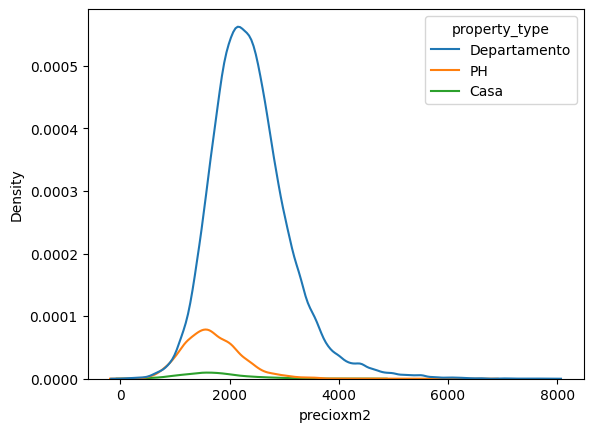

In [145]:
sns.kdeplot(data=df.loc[df['precioxm2'] < 8000], x = 'precioxm2', hue='property_type')
df.loc[df['precioxm2'] < 8000]

In [ ]:
sns.kdeplot(data=df, x="precioxm2", hue="property_type", gridsize=15)

In [ ]:
df.loc[df['property_type'].isin(["Casa"])]['tipo_precio'].hist()

In [ ]:
df.loc[df['property_type'].isin(["Departamento"])]['tipo_precio'].hist()

In [ ]:
df.loc[df['property_type'].isin(["PH"])]['tipo_precio'].hist()

De analizar el gráfico resultante para el tipo de precio de las propiedades de tipo "PH" podemos ver que la mayor cantidad de publicaciones (aproximadamente 3000) tienen un precio alto en comparación con las demás. Adicionalmente podemos ver que hay cerca de unas 2500 publicaciones con precios bajo y medio.

## **3b. Entrenamiento y Predicción**

In [ ]:
df.head()

In [ ]:
ds_trabajo=df.drop(['Survived'], axis='columns')

#  **4. Regresión**

#  **5. Conclusiones**